# Promoter Designer Evaluation

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Transform, constraints
from torch.nn.functional import pad
from torch.autograd import grad
from torch.distributions.beta import Beta, Dirichlet

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import one_hot

import pyBigWig
import tabix
from selene_sdk.targets import Target

import sys
sys.path.append("../")

from ddsm import * 
from selene_utils2 import *


In [63]:
max_time = 2 
min_time = 2 / 2000
n_time_steps = 2000

d = torch.load('/archive/bioinformatics/Zhou_lab/shared/pavdeyev/sde3/maxt2.2000/4C.maxt2.2000.100000.pth') # presampled_4C_maxt4.400.100000.pth') # presampled_4C_maxt4.100000.pth')
for k in d:
    globals()[k]=d[k]
    
alpha = torch.FloatTensor([1.0, 1.0, 1.0])
beta = torch.FloatTensor([3.0, 2.0, 1.0])
torch.set_default_dtype(torch.float32)




    
# #fragment_len = 4096 # 8kb
# fragment_len = 256 # 
# channel_num = 4


In [36]:
print(timepoints)
print(timepoints.shape)

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12
 0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18
 0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24
 0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3
 0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36
 0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415 0.42
 0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475 0.48
 0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535 0.54
 0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585 0.59  0.595 0.6
 0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645 0.65  0.655 0.66
 0.665 0.67  0.675 0.68  0.685 0.69  0.695 0.7   0.705 0.71  0.715 0.72
 0.725 0.73  0.735 0.74  0.745 0.75  0.755 0.76  0.765 0.77  0.775 0.78
 0.785 0.79  0.795 0.8   0.805 0.81  0.815 0.82  0.825 0.83  0.835

In [54]:
class GenomicSignalFeatures(Target):
    """
    #Accept a list of cooler files as input.
    """
    def __init__(self, input_paths, features, shape, blacklists=None, blacklists_indices=None, 
        replacement_indices=None, replacement_scaling_factors=None):
        """
        Constructs a new `GenomicFeatures` object.
        """
        self.input_paths = input_paths
        self.initialized = False
        self.blacklists = blacklists
        self.blacklists_indices = blacklists_indices
        self.replacement_indices = replacement_indices
        self.replacement_scaling_factors = replacement_scaling_factors

            
        self.n_features = len(features)
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)])
        self.shape = (len(input_paths), *shape)

    def get_feature_data(self, chrom, start, end, nan_as_zero=True, feature_indices=None):
        if not self.initialized:
            self.data = [pyBigWig.open(path) for path in self.input_paths]
            if self.blacklists is not None:
                self.blacklists = [tabix.open(blacklist)  for blacklist in self.blacklists]
            self.initialized=True

        if feature_indices is None:
            feature_indices = np.arange(len(self.data))

        wigmat = np.zeros((len(feature_indices), end - start), dtype=np.float32)
        for i in feature_indices:
            try:
                wigmat[i, :] = self.data[i].values(chrom, start, end, numpy=True)
            except:
                print(chrom, start, end, self.input_paths[i], flush=True)
                raise
        
        if self.blacklists is not None:
            if self.replacement_indices is None:
                if self.blacklists_indices is not None:
                    for blacklist, blacklist_indices in zip(self.blacklists, self.blacklists_indices):
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = 0
                else:
                    for blacklist in self.blacklists:
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[:, np.fmax(int(s)-start,0): int(e)-start] = 0
            else:
                for blacklist, blacklist_indices, replacement_indices, replacement_scaling_factor in zip(self.blacklists, self.blacklists_indices, self.replacement_indices, self.replacement_scaling_factors):
                    for _, s, e in blacklist.query(chrom, start, end):
                        wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = wigmat[replacement_indices, np.fmax(int(s)-start,0): int(e)-start] * replacement_scaling_factor

        if nan_as_zero:
            wigmat[np.isnan(wigmat)]=0
        return wigmat

    
class TSSDatasetS(Dataset):
    def __init__(self, seqlength=1024, split="train", n_tsses=100000, rand_offset=0):
        self.shuffle = False
        #import selene_sdk

        self.genome = MemmapGenome(
            input_path='/archive/bioinformatics/Zhou_lab/shared/jzhou/GraphSeq/Homo_sapiens.GRCh38.dna.primary_assembly.fa',
            memmapfile='/archive/bioinformatics/Zhou_lab/shared/jzhou/GraphSeq/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap',
            blacklist_regions= 'hg38'
        )
        self.tfeature = GenomicSignalFeatures(["/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/agg.plus.bw.bedgraph.bw", 
"/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/agg.minus.bw.bedgraph.bw"],
                               ['cage_plus','cage_minus'],
                               (2000,),
                               ["/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/fantom.blacklist8.plus.bed.gz","/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/fantom.blacklist8.minus.bed.gz"])

        self.tsses = pd.read_table('/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/analysis/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v4.tsv', sep='\t')
        self.tsses = self.tsses.iloc[:n_tsses,:]
        
        self.chr_lens = self.genome.get_chr_lens()
        self.split = split
        if split == "train":
            self.tsses = self.tsses.iloc[~np.isin(self.tsses['chr'].values, ['chr8', 'chr9', 'chr10'])]
        elif split == "valid":
            self.tsses = self.tsses.iloc[np.isin(self.tsses['chr'].values, ['chr10'])]
        elif split == "test":
            self.tsses = self.tsses.iloc[np.isin(self.tsses['chr'].values, ['chr8', 'chr9'])]
        else:
            raise ValueError
        self.rand_offset = rand_offset
        self.seqlength = seqlength
        
    def __len__(self):
        return self.tsses.shape[0]

    def __getitem__(self, tssi):
        chrm, pos, strand = self.tsses['chr'].values[tssi], self.tsses['TSS'].values[tssi], self.tsses['strand'].values[tssi]
        offset = 1 if strand == '-' else 0

        offset = offset + np.random.randint(-self.rand_offset,self.rand_offset+1)
        seq = self.genome.get_encoding_from_coords(chrm, pos-int(self.seqlength/2)+offset, pos+int(self.seqlength/2)+offset, strand)

        signal = self.tfeature.get_feature_data(chrm, pos-int(self.seqlength/2)+offset, pos+int(self.seqlength/2)+offset)
        if strand == '-':
            signal=signal[::-1,::-1]
        return np.concatenate([seq, signal.T], axis=-1).astype(np.float32)
    
    def reset(self):
        np.random.seed(0)
        
#%%
def output2encoding(samples):
    samples = samples.detach().cpu()
    sequence_tensor = torch.argmax(samples, dim=2)
    encoding = one_hot(sequence_tensor)
    return encoding

def output2seq(samples):
    samples = samples.detach().cpu()
    sequence_tensor = torch.argmax(samples, dim=2)
    sequences = ["" for _ in range(sequence_tensor.shape[0])]
    bases_arr = "ACGT"
    for num in range(sequence_tensor.shape[0]):
        for pos in range(sequence_tensor.shape[1]):
            sequences[num] += bases_arr[sequence_tensor[num, pos]]
    return sequences

def GC_content(samples):
    samples = output2encoding(samples)
    base_counts = torch.sum(samples, dim=(0, 1))
    GC_percentage = (base_counts[1]+base_counts[2])/torch.sum(base_counts) * 100
    return GC_percentage.item()


def dinucle_per(samples):
    samples = samples.detach().cpu()
    sequence_tensor = torch.argmax(samples, dim=2)
    channel_num = samples.shape[2]
    dinucle_counts = torch.zeros(channel_num * channel_num)
    for num in range(sequence_tensor.shape[0]):
        for pos in range(sequence_tensor.shape[1]-1):
            base1 = sequence_tensor[num, pos]
            base2 = sequence_tensor[num, pos+1]
            dinucle_counts[base1 * 4 + base2] += 1
    dinucle_percentage = dinucle_counts /torch.sum(dinucle_counts) * 100
    return dinucle_percentage


In [38]:
class Dense(nn.Module):
    
    """
    A fully connected layer that reshapes outputs to feature maps.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[...]

    
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, embed_dim=256, time_dependent_weights=None, time_step=0.01):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    n=256
    self.linear = nn.Conv1d(5, n, kernel_size=9, padding=4)
    self.blocks = nn.ModuleList([nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256)])



    self.denses = nn.ModuleList([Dense(embed_dim, n) for _ in range(20)])
    self.norms = nn.ModuleList([nn.GroupNorm(1,n) for _ in range(20)])


    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus()
    self.scale = nn.Parameter(torch.ones(1))
    self.final =  nn.Sequential(nn.Conv1d(n, n, kernel_size=1),
                                nn.GELU(),
                                nn.Conv1d(n, 4, kernel_size=1))
    self.register_buffer("time_dependent_weights", time_dependent_weights)
    self.time_step = time_step
    
  def forward(self, x, t, t_ind=None, return_a=False):
    # Obtain the Gaussian random feature embedding for t
    # embed: [N, embed_dim]
    embed = self.act(self.embed(t/2))

    # Encoding path
    # x: NLC -> NCL
    out = x.permute(0, 2, 1)
    out = self.act(self.linear(out))
    #pos encoding
    #out = torch.cat([out, (torch.linspace(0,1,1024)-0.5).cuda()[None,None:].expand(out.shape[0],1, 1024,) ], 1)
    for block, dense, norm in zip(self.blocks, self.denses, self.norms):
        h = self.act(block(norm(out + dense(embed)[:,:,None])))
        if h.shape == out.shape:
            out = h + out
        else:
            out = h

    
    out = self.final(out)
    #if return_a:
    #    out = out.permute(0, 2, 1) * torch.exp(-t[:,None,None]* self.softplus(self.scale)) #/ torch.sqrt((x+1e-3)*(1-x+1e-3))
    #else:
    #if self.time_dependent_weights is not None:
    out = out.permute(0, 2, 1) #* self.time_dependent_weights[(t/self.time_step-1).long(),None,None] / ((x+1e-6)*(1-x+1e-6))
    if self.time_dependent_weights is not None:
        t_step = (t/self.time_step)-1
        w0 = self.time_dependent_weights[t_step.long()]
        w1 = self.time_dependent_weights[torch.clip(t_step+1,max=len(self.time_dependent_weights)-1).long()]
        out = out *  (w0 + (t_step-t_step.floor())*(w1-w0))[:,None,None]

    out = out - out.mean(axis=-1, keepdims=True)
    return out


In [64]:
#importance sampling weights 
#this part may change, no need to spend too much time on understanding it


import sys
import torch
import numpy as np
import pandas as pd
import functools
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


device = 'cuda'
batch_size =  256 
random_order=False
speed_balanced=False
C = 4

def worker_init_fn(worker_id):                                                          
    np.random.seed(worker_id)

sb = UnitStickBreakingTransform()

train_set = TSSDatasetS(n_tsses=40000, rand_offset=10)
data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

time_dependent_cums = torch.zeros(n_time_steps).to(device)
time_dependent_counts = torch.zeros(n_time_steps).to(device)

avg_loss = 0.
num_items = 0
for i, x in enumerate(data_loader):
    x = x[...,:4]
    random_t = torch.randint(0,n_time_steps, (x.shape[0],))
    
    order = np.random.permutation(np.arange(C))
    #
    if random_order:
        #perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x[...,order], random_t, v_one, v_one_loggrad)
        perturbed_x, perturbed_x_grad = diffusion_factory(x[...,order], random_t,  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
        perturbed_x = perturbed_x[..., np.argsort(order)]
        perturbed_x_grad = perturbed_x_grad[..., np.argsort(order)]
    else:
        #perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)
        perturbed_x, perturbed_x_grad = diffusion_factory(x, random_t,  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
    perturbed_x = perturbed_x.to(device)    
    perturbed_x_grad = perturbed_x_grad.to(device)
    random_t = random_t.to(device)
    perturbed_v = sb._inverse(perturbed_x)

    
    order = np.random.permutation(np.arange(C))
    if random_order:
        perturbed_v = sb._inverse(perturbed_x[..., order], prevent_nan=True).detach()
    else:
        perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()


    time_dependent_counts[random_t] += 1
    #time_dependent_cums[random_t] +=  ( ((perturbed_x)*(1-perturbed_x))**2 * (perturbed_x_grad)**2).mean(dim=(1,2,3)).detach()
    if speed_balanced:
        s = 2/(torch.ones(C-1, device=device)+torch.arange(C-1,0,-1, device=device).float())
    else:
        s = torch.ones(C-1, device=device)
        
    if random_order:
        time_dependent_cums[random_t] +=  (perturbed_v*(1-perturbed_v) * s[(None,)*(x.ndim-1)] * (gx_to_gv(perturbed_x_grad[...,order],perturbed_x[...,order]))**2).view(x.shape[0],-1).mean(dim=1).detach()
    else:
        time_dependent_cums[random_t] +=  (perturbed_v*(1-perturbed_v) * s[(None,)*(x.ndim-1)] * (gx_to_gv(perturbed_x_grad,perturbed_x))**2).view(x.shape[0],-1).mean(dim=1).detach()

    time_dependent_weights =  time_dependent_cums / time_dependent_counts
    time_dependent_weights = time_dependent_weights / time_dependent_weights.mean()


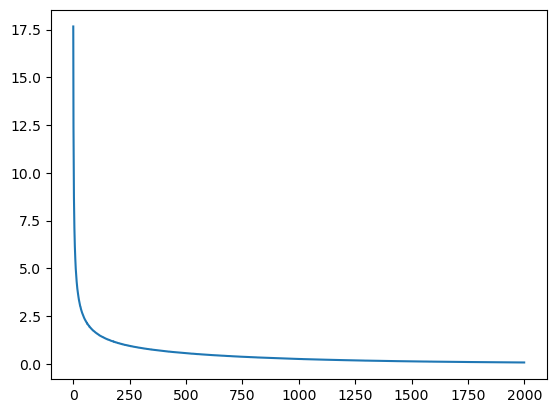

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(torch.sqrt(time_dependent_weights.cpu()))

In [66]:
import torch
from torch import nn
from torch.autograd import grad

from torch_fftconv import fft_conv1d, FFTConv1d
# from fft_conv_pytorch import FFTConv1d
import numpy as np
from copy import deepcopy

class simpleNet(nn.Module):
    def __init__(self):

        super(simpleNet, self).__init__()
        self.conv = nn.Conv1d(4,  10, kernel_size=51, padding=25)
        #self.conv_sim = nn.Conv1d(4,  1, kernel_size=51, padding=25)
        #self.conv_mono = nn.Conv1d(4,  4, kernel_size=1, padding=0)
        self.conv_inr = nn.Conv1d(4,  10, kernel_size=15, padding=7)
        self.conv_sim = nn.Conv1d(4,  32, kernel_size=3, padding=1)

        self.activation = nn.Softplus()

        #self.deconv = nn.ConvTranspose1d(18,  10, kernel_size=601, padding=300)
        self.deconv = FFTConv1d(10*2,  10, kernel_size=601, padding=300)
        self.deconv_sim = FFTConv1d(64,  10, kernel_size=601, padding=300)
        #self.deconv_mono = nn.ConvTranspose1d(4,  10, kernel_size=401, padding=200)
        self.deconv_inr = nn.ConvTranspose1d(20,  10, kernel_size=15, padding=7)

        self.scaler = nn.Parameter(torch.ones(1))
        self.scaler2 = nn.Parameter(torch.ones(1))

        #self.conv_mono.weight.data.fill_(0)
        #self.conv_mono.bias.data.fill_(0)
        #self.conv_mono.weight.data[0,0,0]=1
        #self.conv_mono.weight.data[1,1,0]=1
        #self.conv_mono.weight.data[2,2,0]=1
        #self.conv_mono.weight.data[3,3,0]=1
        #self.conv_mono.weight.requires_grad=False
        #self.conv_mono.bias.requires_grad=False

    def forward(self, x):
        y = torch.cat([self.conv(x), self.conv(x.flip([1,2])).flip([2])], 1)
        y_sim = torch.cat([self.conv_sim(x), self.conv_sim(x.flip([1,2])).flip([2])], 1)
        y_inr = torch.cat([self.conv_inr(x), self.conv_inr(x.flip([1,2])).flip([2])], 1)
        #y_mono = self.conv_mono(x)
        #y_sim = torch.cat([self.conv_sim(x), self.conv_sim(x.flip([1,2])).flip([2])], 1)

        yact = self.activation(y )
        y_sim_act = self.activation(y_sim) #* y_sim
        y_inr_act = self.activation(y_inr)
        #y_sim_act = self.activation(y_sim)#*y_sim

        y_pred = self.activation(self.deconv(yact)+self.deconv_inr(y_inr_act)+self.deconv_sim(y_sim_act))
        return y_pred

net = simpleNet()
#net.load_state_dict(torch.load('/endosome/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/models/sikinr300c2a3fFA2ata2c0v3_10motifs_tss40000_0.pth'))
net.load_state_dict(torch.load('/endosome/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/models/sikinr300c2a3fFA2ata2c0v4cSa1gf1_10motifs_s3bc4d2_tss40000_0.pth'))
net.cuda()

simpleNet(
  (conv): Conv1d(4, 10, kernel_size=(51,), stride=(1,), padding=(25,))
  (conv_inr): Conv1d(4, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv_sim): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (activation): Softplus(beta=1, threshold=20)
  (deconv): FFTConv1d(20, 10, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_sim): FFTConv1d(64, 10, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_inr): ConvTranspose1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
)

In [67]:
#Sei model
#here we specify using GPU number 0
#you should use nvidia-smi to see whether GPU has more free memory and choose to least used one
import os 
#os.environ['CUDA_VISIBLE_DEVICES']="0"

#need to install torch and selene_sdk following their instructions
import torch
from torch import nn
import selene_sdk
from selene_sdk.utils import NonStrandSpecific
import sys
sys.path.append('/endosome/archive/bioinformatics/Zhou_lab/shared/jzhou/Code/TSS/')
from Sei import *
import pandas as pd

sei = nn.DataParallel(NonStrandSpecific(Sei(4096, 21907)))
sei.load_state_dict(torch.load('/archive/bioinformatics/Zhou_lab/shared/jzhou/cistrome/2019-07-25-13-21-44-IY28BMRY/best_model.pth.tar', map_location='cpu')['state_dict'])
sei.cuda()

hg38= selene_sdk.sequences.Genome(
                    input_path='/archive/bioinformatics/Zhou_lab/shared/jzhou/GraphSeq/Homo_sapiens.GRCh38.dna.primary_assembly.fa',
                    blacklist_regions= 'hg38'
                )

import pandas as pd
seifeatures = pd.read_csv('/archive/bioinformatics/Zhou_lab/shared/jzhou/sei-framework/model/target.names', sep='|', header=None)

In [69]:
score_model = nn.DataParallel(ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)))
score_model.load_state_dict(torch.load('/archive/bioinformatics/Zhou_lab/shared/pavdeyev/sde3/maxt2.2000/sdedna_promoter_revision.bestvalid.pth'))

score_model.cuda() 
score_model.eval()

DataParallel(
  (module): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Conv1d(5, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (blocks): ModuleList(
      (0): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
      (5): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (6): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilat

In [45]:
sampler = Euler_Maruyama_sampler

In [16]:
test_set = TSSDatasetS(split='test',n_tsses=40000, rand_offset=0)
test_data_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=0)
test_datasets = []
for x in test_data_loader:
    test_datasets.append(x)

In [70]:
#generate sequence samples
torch.set_default_dtype(torch.float32)

allsamples = []
for t in test_datasets:
    samples=[]
    for i in range(5):
        score_model.eval()
        samples.append(sampler(score_model, \
                          (1024,4), \
                          batch_size=t.shape[0], \
                                max_time=max_time, \
                                min_time=min_time, \
                                time_dilation=1,\
                                num_steps=100, \
                                eps=1e-5, \
                          speed_balanced=speed_balanced,\
                          device=device, \
                          concat_input = t[:,:,4:5].cuda()).cpu().detach().numpy())
    allsamples.append(samples)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
#with time-dilation
torch.set_default_dtype(torch.float32)

allsamples2x = []
for t in test_datasets:
    samples=[]
    for i in range(5):
        score_model.eval()
        samples.append(Euler_Maruyama_sampler(score_model, \
                          (1024,4), \
                          batch_size=t.shape[0], \
                                max_time=max_time, \
                                min_time=min_time, \
                                time_dilation=2,\
                                time_dilation_start_time=1,\
                                num_steps=200, \
                                eps=1e-5, \
                          speed_balanced=speed_balanced,\
                          device=device, \
                          concat_input = t[:,:,4:5].cuda()).cpu().detach().numpy())
    allsamples2x.append(samples)

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

In [26]:
#with time-dilation
torch.set_default_dtype(torch.float32)

allsamples4x = []
for t in test_datasets:
    samples=[]
    for i in range(5):
        score_model.eval()
        samples.append(Euler_Maruyama_sampler(score_model, \
                          (1024,4), \
                          batch_size=t.shape[0], \
                                max_time=max_time, \
                                min_time=min_time, \
                                time_dilation=4,\
                                time_dilation_start_time=1,\
                                num_steps=400, \
                                eps=1e-5, \
                          speed_balanced=speed_balanced,\
                          device=device, \
                          concat_input = t[:,:,4:5].cuda()).cpu().detach().numpy())
    allsamples4x.append(samples)

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

In [27]:
for i in range(len(allsamples)):
    for j in range(len(allsamples[i])):
        allsamples[i][j] = allsamples[i][j].cpu().detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [62]:
for i in range(len(allsamples2x)):
    for j in range(len(allsamples2x[i])):
        allsamples2x[i][j] = allsamples2x[i][j].cpu().detach().numpy()

In [ ]:
for i in range(len(allsamples4x)):
    for j in range(len(allsamples4x[i])):
        allsamples4x[i][j] = allsamples4x[i][j].cpu().detach().numpy()

In [71]:
allsamples = np.concatenate(allsamples, axis=1)

In [29]:
allsamples2x = np.concatenate(allsamples2x, axis=1)

In [30]:
allsamples4x = np.concatenate(allsamples4x, axis=1)

In [24]:
np.save(arr=allsamples, file='allsamples.revision1.npy')
np.save(arr=allsamples2x, file='allsamples.tdilation2x_tdsf1.revision1.npy')
np.save(arr=allsamples4x, file='allsamples.tdilation4x_tdsf1.revision1.npy')

In [2]:
import numpy as np
allsamples = np.load('allsamples.npy')
allsamples2x = np.load('allsamples.tdilation2x_tdsf1.npy')

In [72]:
testseqs = np.concatenate(test_datasets, axis=0)[:,:,:4]

In [73]:
allsamples_pred = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples[j].shape[0]/128)):
        seq = 1.0* (allsamples[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples[j][-128:]
    allsamples_pred[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [ ]:
allsamples_pred2x = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples2x[j].shape[0]/128)):
        seq = 1.0* (allsamples2x[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred2x[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples2x[j][-128:]
    allsamples_pred2x[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [33]:
allsamples_pred4x = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples4x[j].shape[0]/128)):
        seq = 1.0* (allsamples4x[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred4x[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples4x[j][-128:]
    allsamples_pred4x[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [21]:
with torch.no_grad():
    testseqs_pred = np.zeros((2915, 21907))
    for i in range(int(testseqs.shape[0]/128)):
        testseq = testseqs[i*128:(i+1)*128]
        testseqs_pred[i*128:(i+1)*128] =  sei(torch.cat([torch.ones((testseq.shape[0],4,1536))*0.25, torch.FloatTensor(testseq).transpose(1,2), 
                   torch.ones((testseq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    testseq = testseqs[-128:]
    testseqs_pred[-128:] =  sei(torch.cat([torch.ones((testseq.shape[0],4,1536))*0.25, torch.FloatTensor(testseq).transpose(1,2), 
                   torch.ones((testseq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [74]:
testseqs_predh3k4me3 = testseqs_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=1)

In [75]:
allsamples_predh3k4me3 = allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

In [39]:
allsamples2x_predh3k4me3 = allsamples_pred2x[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

In [40]:
allsamples4x_predh3k4me3 = allsamples_pred4x[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

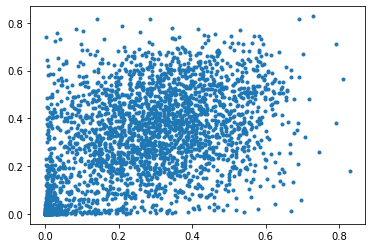

In [48]:
plt.plot(allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1).mean(0),
        testseqs_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1),'.')

In [76]:
acc = []
for i in range(5):
    acc.append(((allsamples_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(0.05579084080990043, 0.0006149178831280286)

In [42]:
acc = []
for i in range(5):
    acc.append(((allsamples2x_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(0.03515263329260012, 0.0003706440086658039)

In [43]:
acc = []
for i in range(5):
    acc.append(((allsamples4x_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(0.040454501907953744, 0.00033130965396008347)

In [22]:
%load_ext rpy2.ipython

In [23]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

R[write to console]: Loading required package: scales




  0-10%  10-20%  20-30%  30-40%  40-50%  50-60%  60-70%  70-80%  80-90% 90-100% 
    292     291     292     291     292     291     291     292     291     292 


R[write to console]: Saving 10 x 6 in image



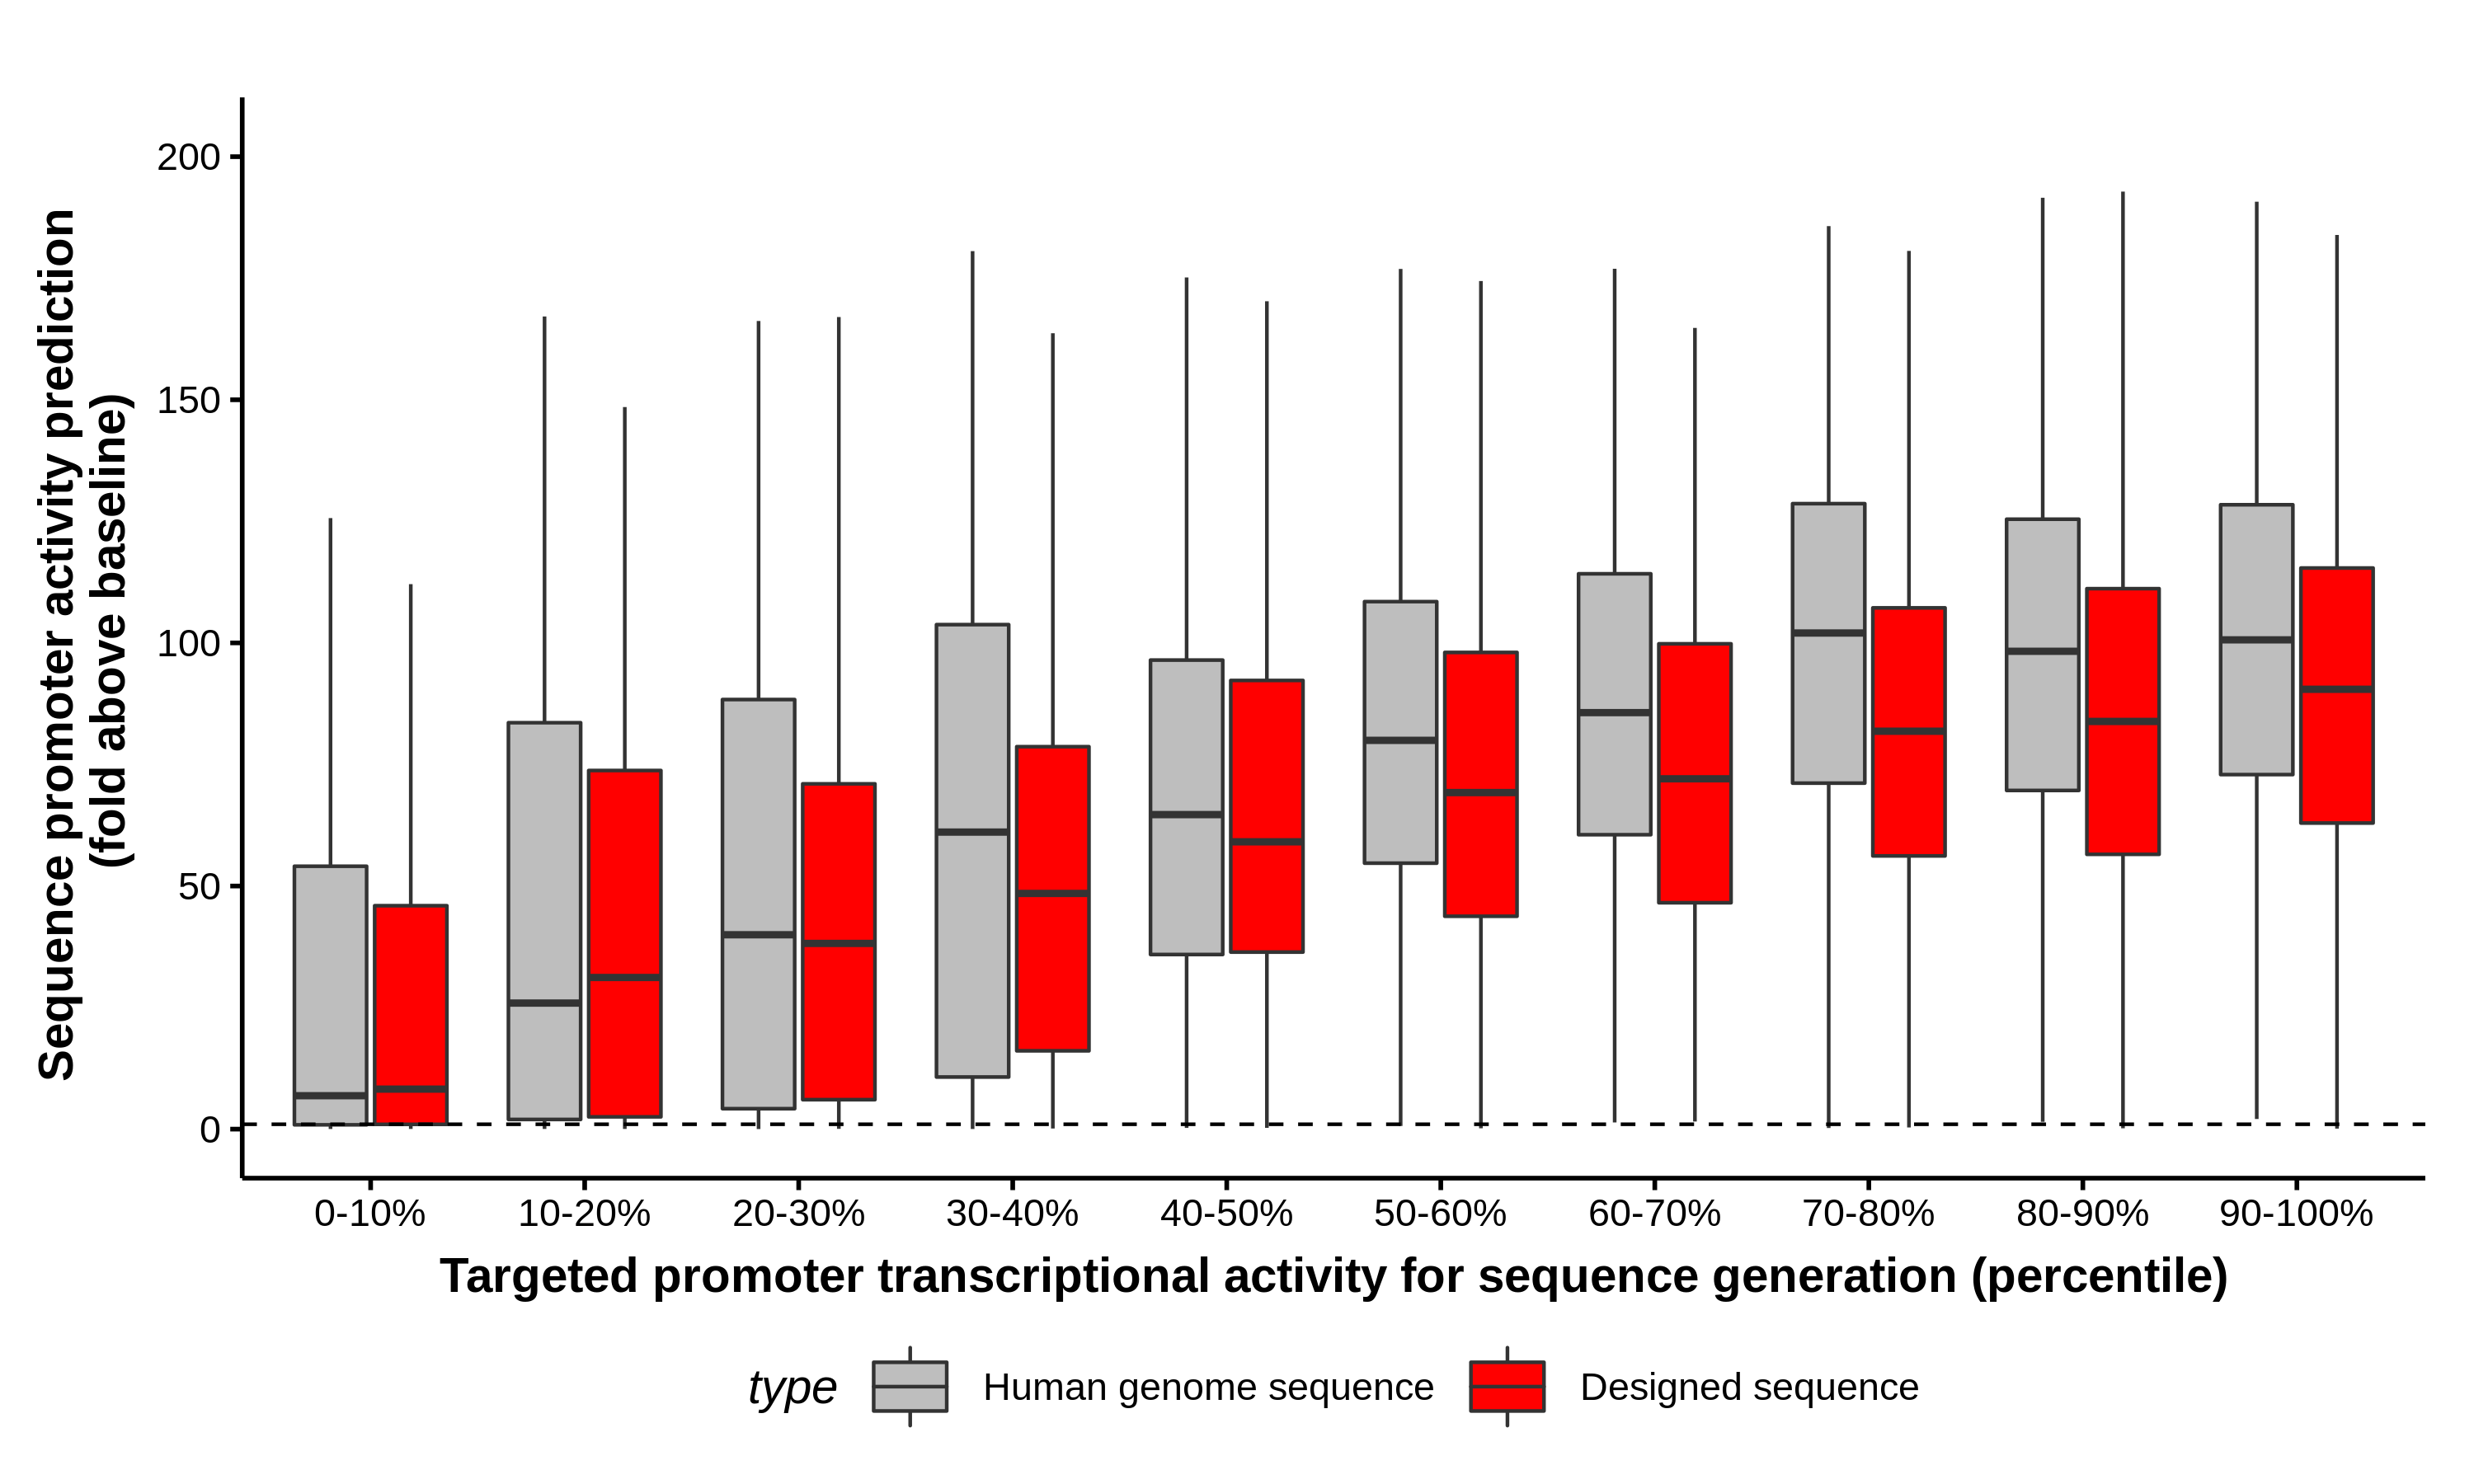

In [313]:
%%R -i testseqs_predh3k4me3,allsamples_predh3k4me3,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_predh3k4me4/0.004138, type='Human genome sequence'),
      data.frame(x=cutp(log10(1+exp)), y=allsamples_predh3k4me3[1,]/0.004138, type='Designed sequence'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red'))+geom_hline(yintercept=1, linetype=2)#+
    #coord_cartesian(ylim=c(0,180))
#ggsave('./figures/compare_seqs.pdf', device=cairo_pdf)
p


  0-10%  10-20%  20-30%  30-40%  40-50%  50-60%  60-70%  70-80%  80-90% 90-100% 
    292     291     292     291     292     291     291     292     291     292 


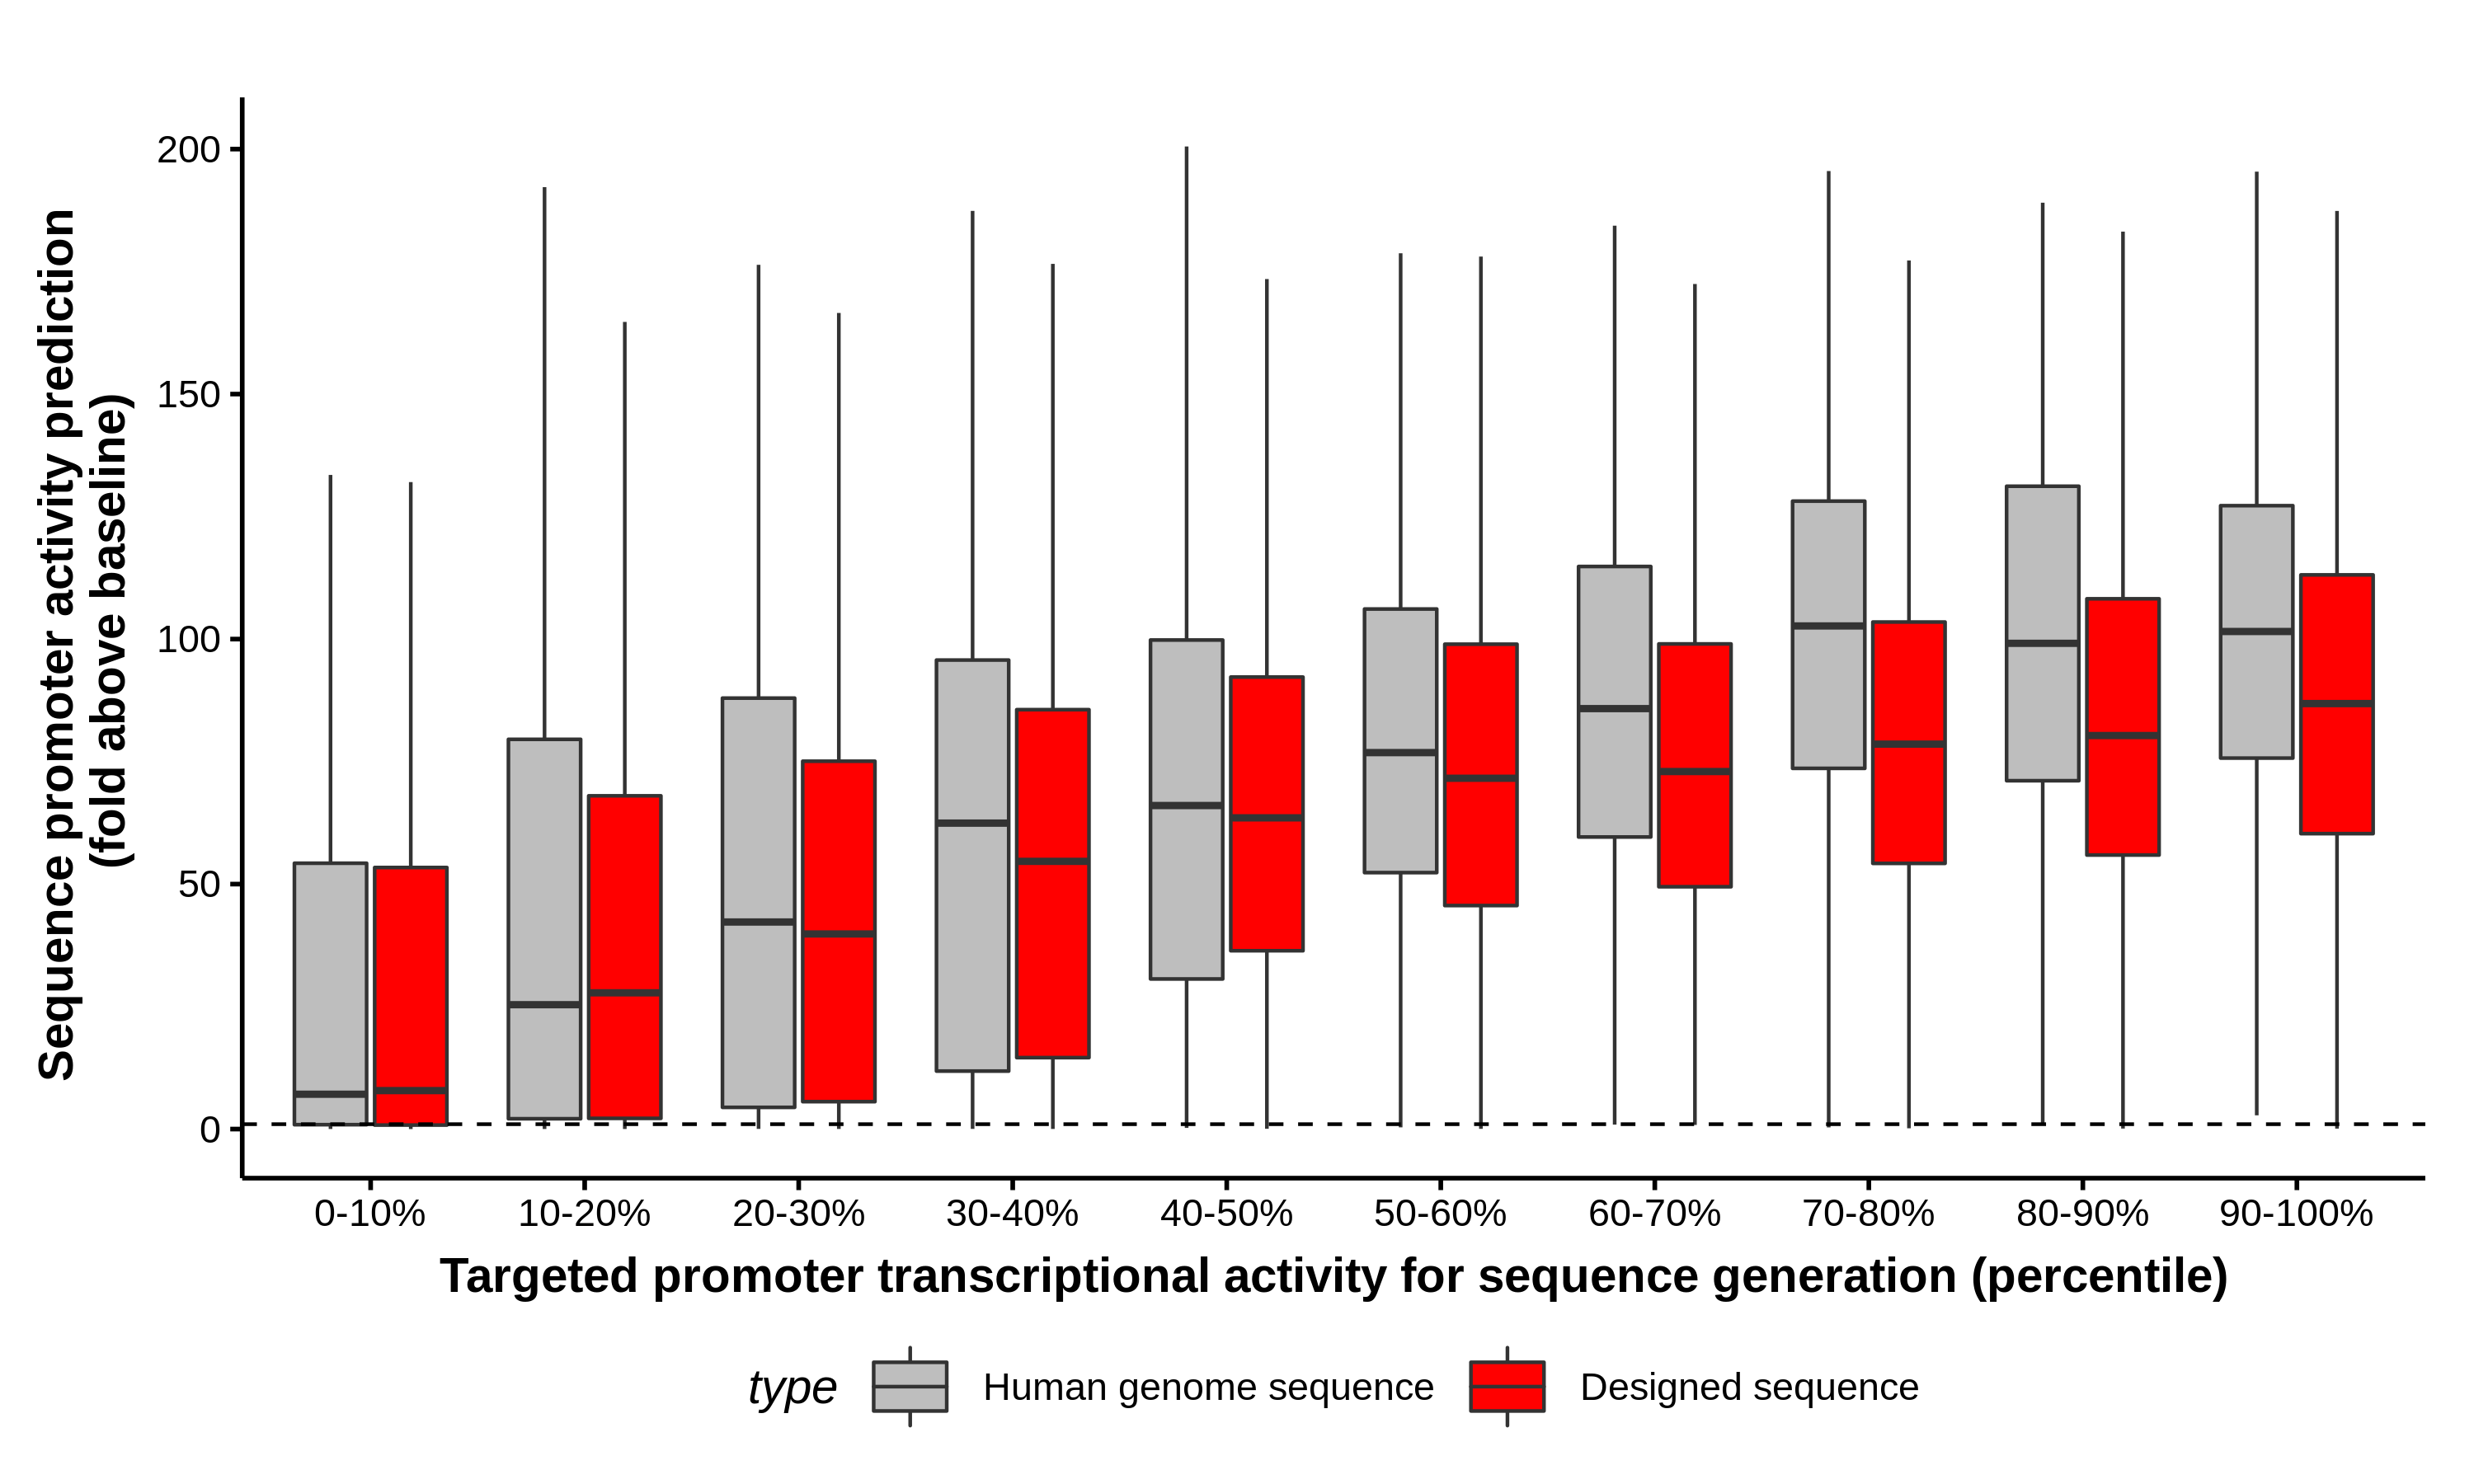

In [60]:
%%R -i testseqs_predh3k4me3,allsamples_predh3k4me3,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_predh3k4me3/0.004138, type='Human genome sequence'),
      data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples_predh3k4me3)/0.004138, type='Designed sequence'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red'))+geom_hline(yintercept=1, linetype=2)#+
    #coord_cartesian(ylim=c(0,180))
#ggsave('./figures/compare_seqs.pdf', device=cairo_pdf)
p


  0-10%  10-20%  20-30%  30-40%  40-50%  50-60%  60-70%  70-80%  80-90% 90-100% 
    292     291     292     291     292     291     291     292     291     292 


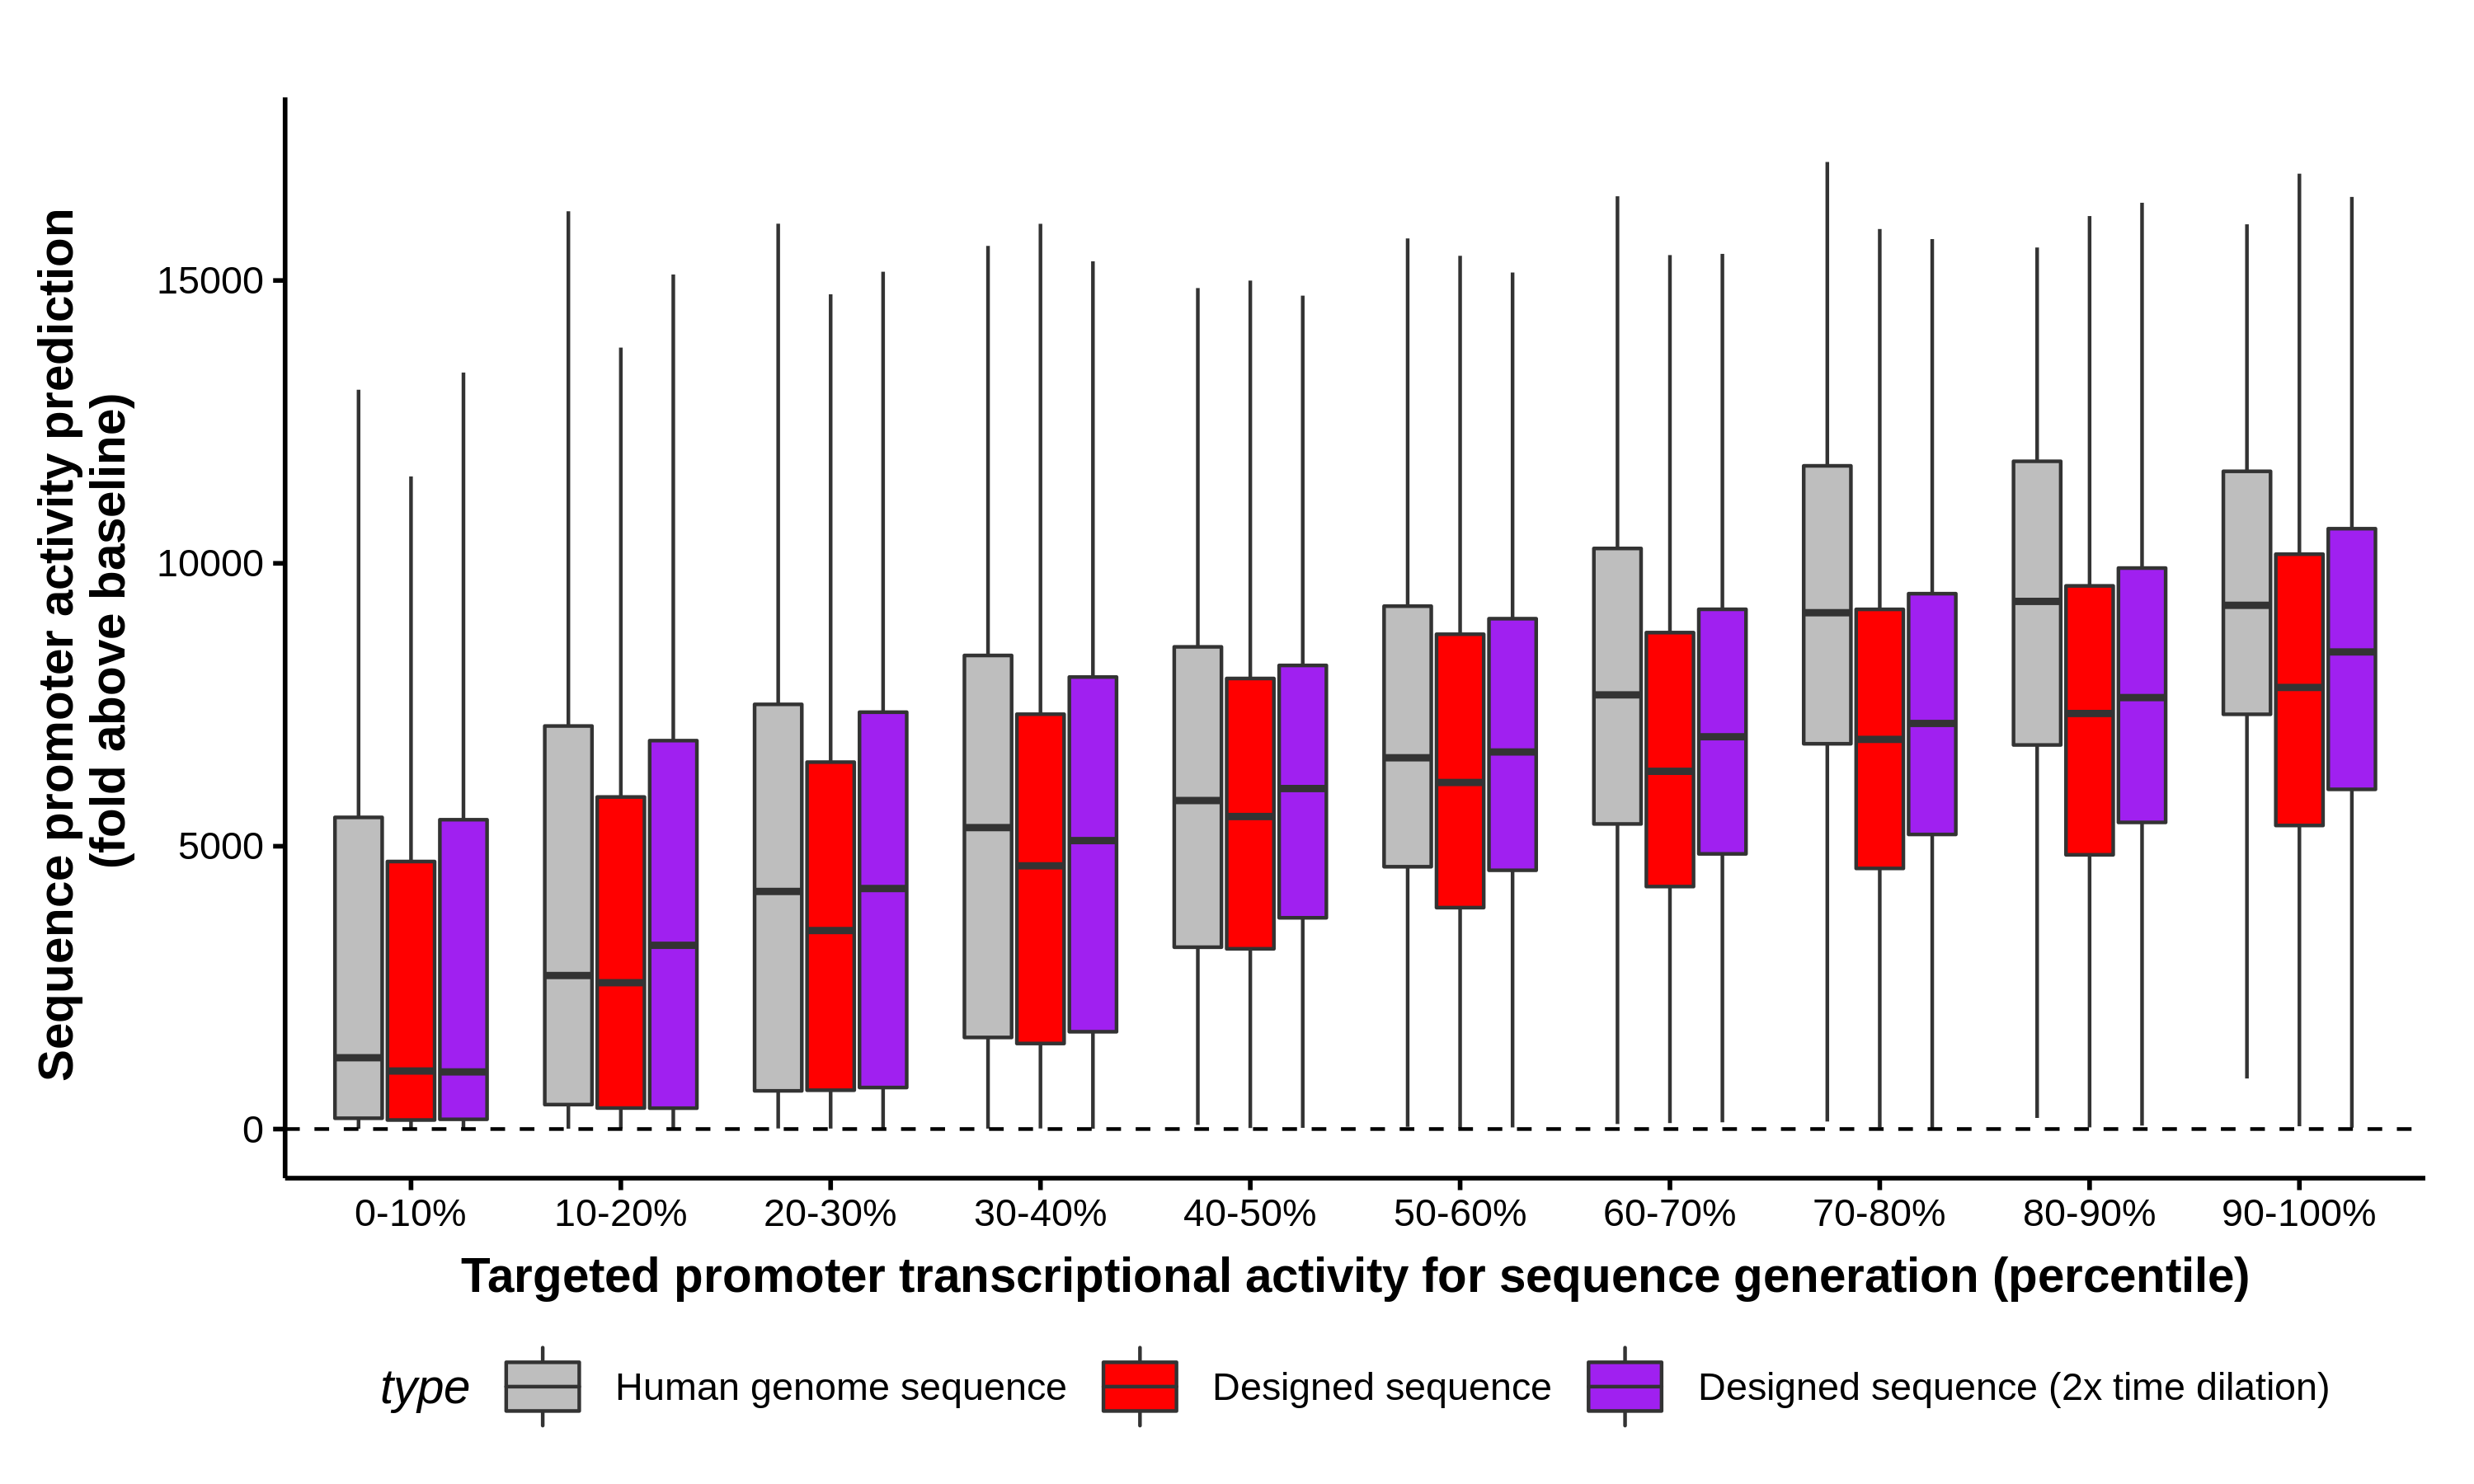

In [73]:
%%R -i testseqs_scpred,allsamples_scpred,allsamples2x_scpred,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_scpred/0.004138, type='Human genome sequence'),
      data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples_scpred)/0.004138, type='Designed sequence'),
       data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples2x_scpred)/0.004138, type='Designed sequence (2x time dilation)'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red','purple'))+geom_hline(yintercept=1, linetype=2)#+
    #coord_cartesian(ylim=c(0,180))
#ggsave('./figures/compare_seqs2.pdf', device=cairo_pdf)
p

In [34]:
sample_bp=allsamples[0,:,:,:].mean(axis=0)
testseqs_bp = testseqs.mean(axis=0)

In [35]:
sample_bp2x=allsamples2x[0,:2915,:,:].mean(axis=0)

R[write to console]: Saving 10 x 4 in image



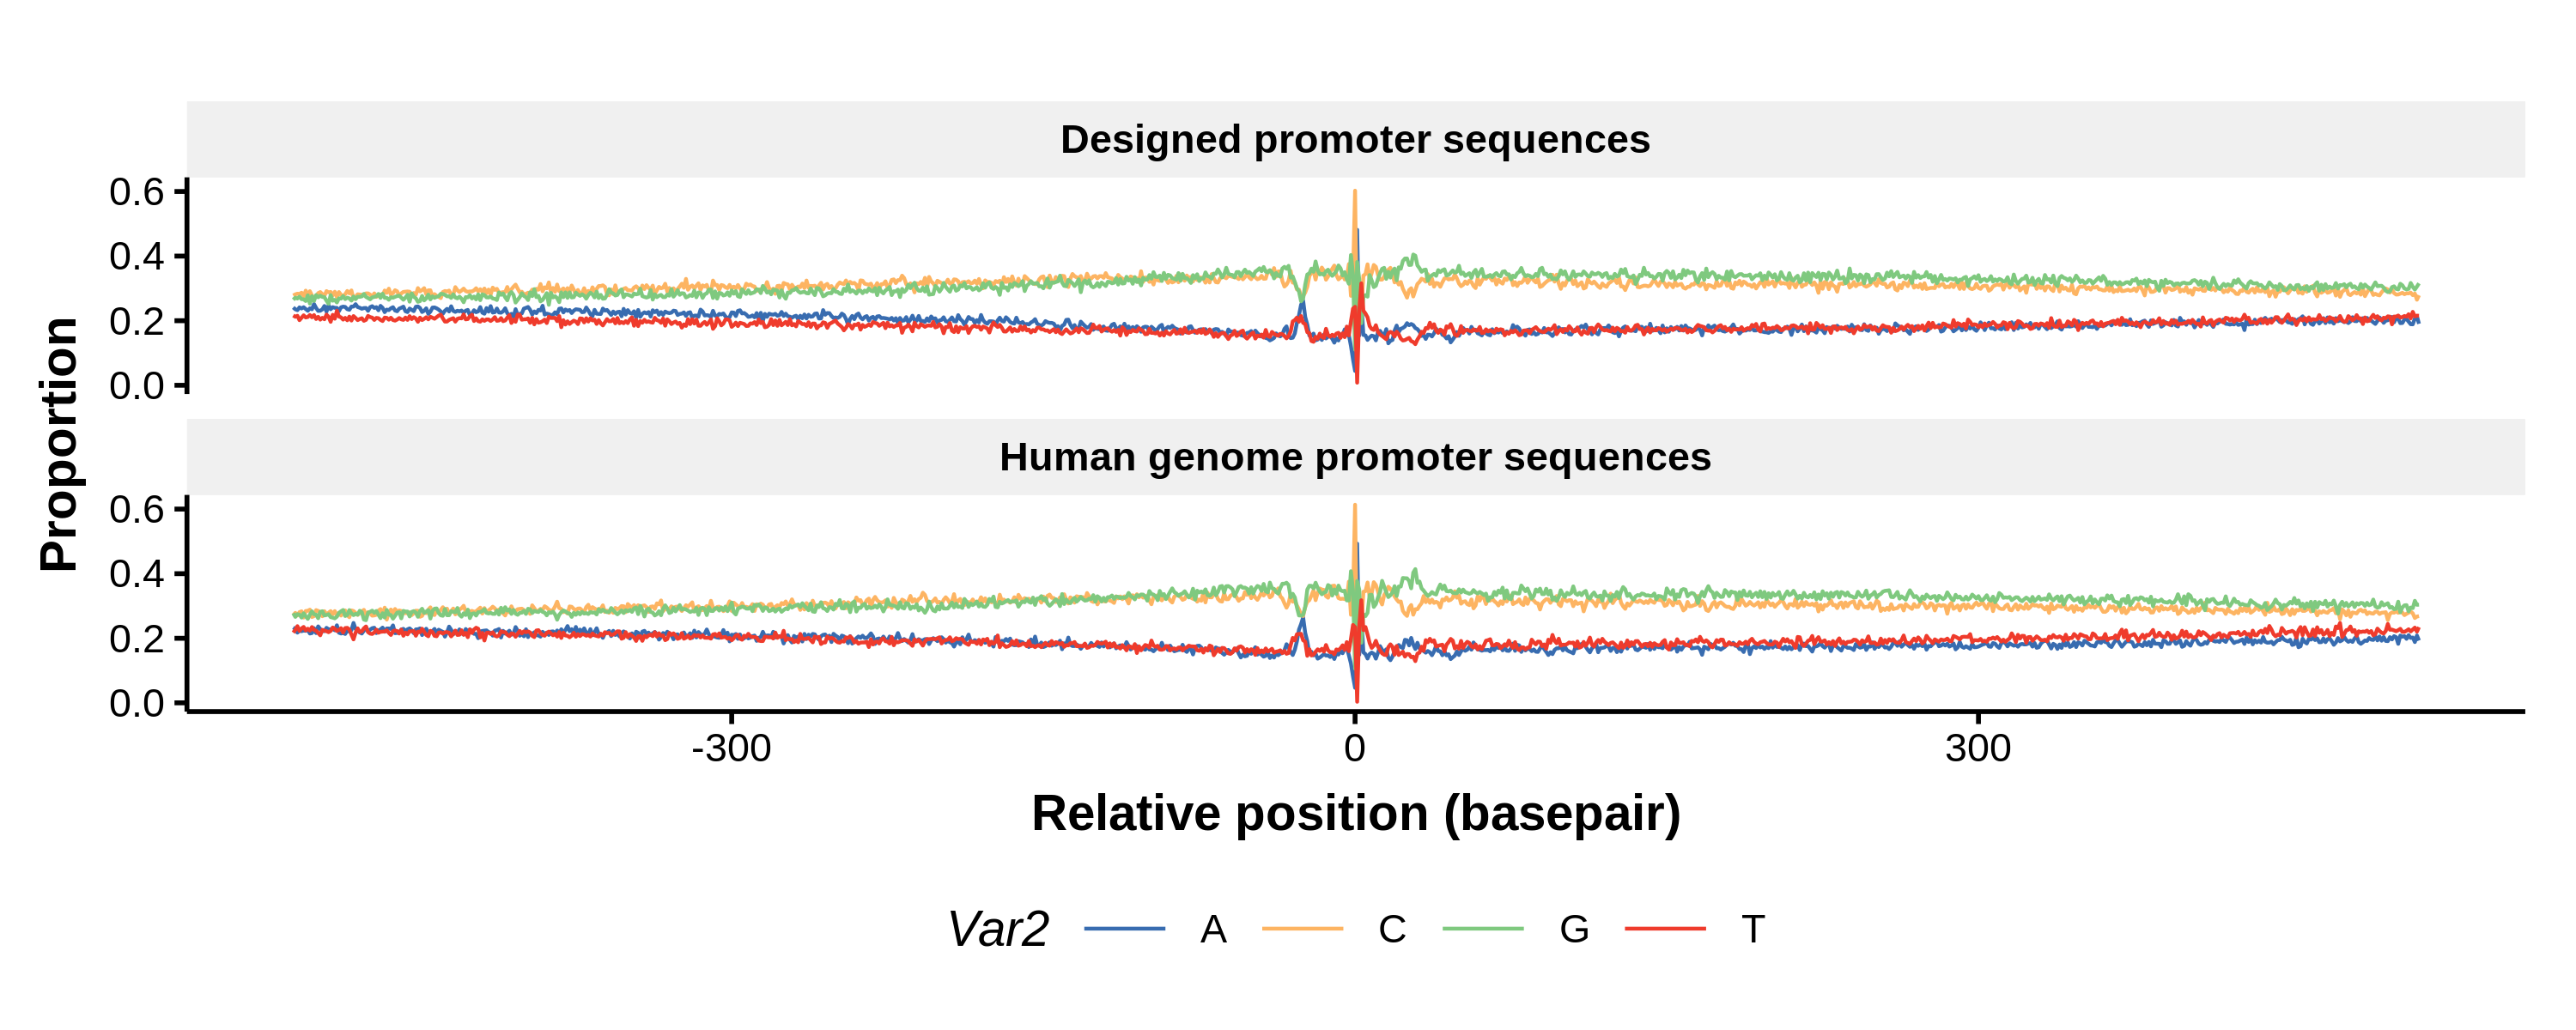

In [239]:
%%R -i sample_bp,testseqs_bp -w 10 -h 4 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp) = c('A','C','G','T')
colnames(testseqs_bp) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp),type='Designed promoter sequences'), 
                 cbind(melt(testseqs_bp),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=2)+xlab('Relative position (basepair)') + ylab('Proportion')

ggsave('./figures/seqs_bp.pdf', device=cairo_pdf)
p

R[write to console]: Saving 10 x 6 in image



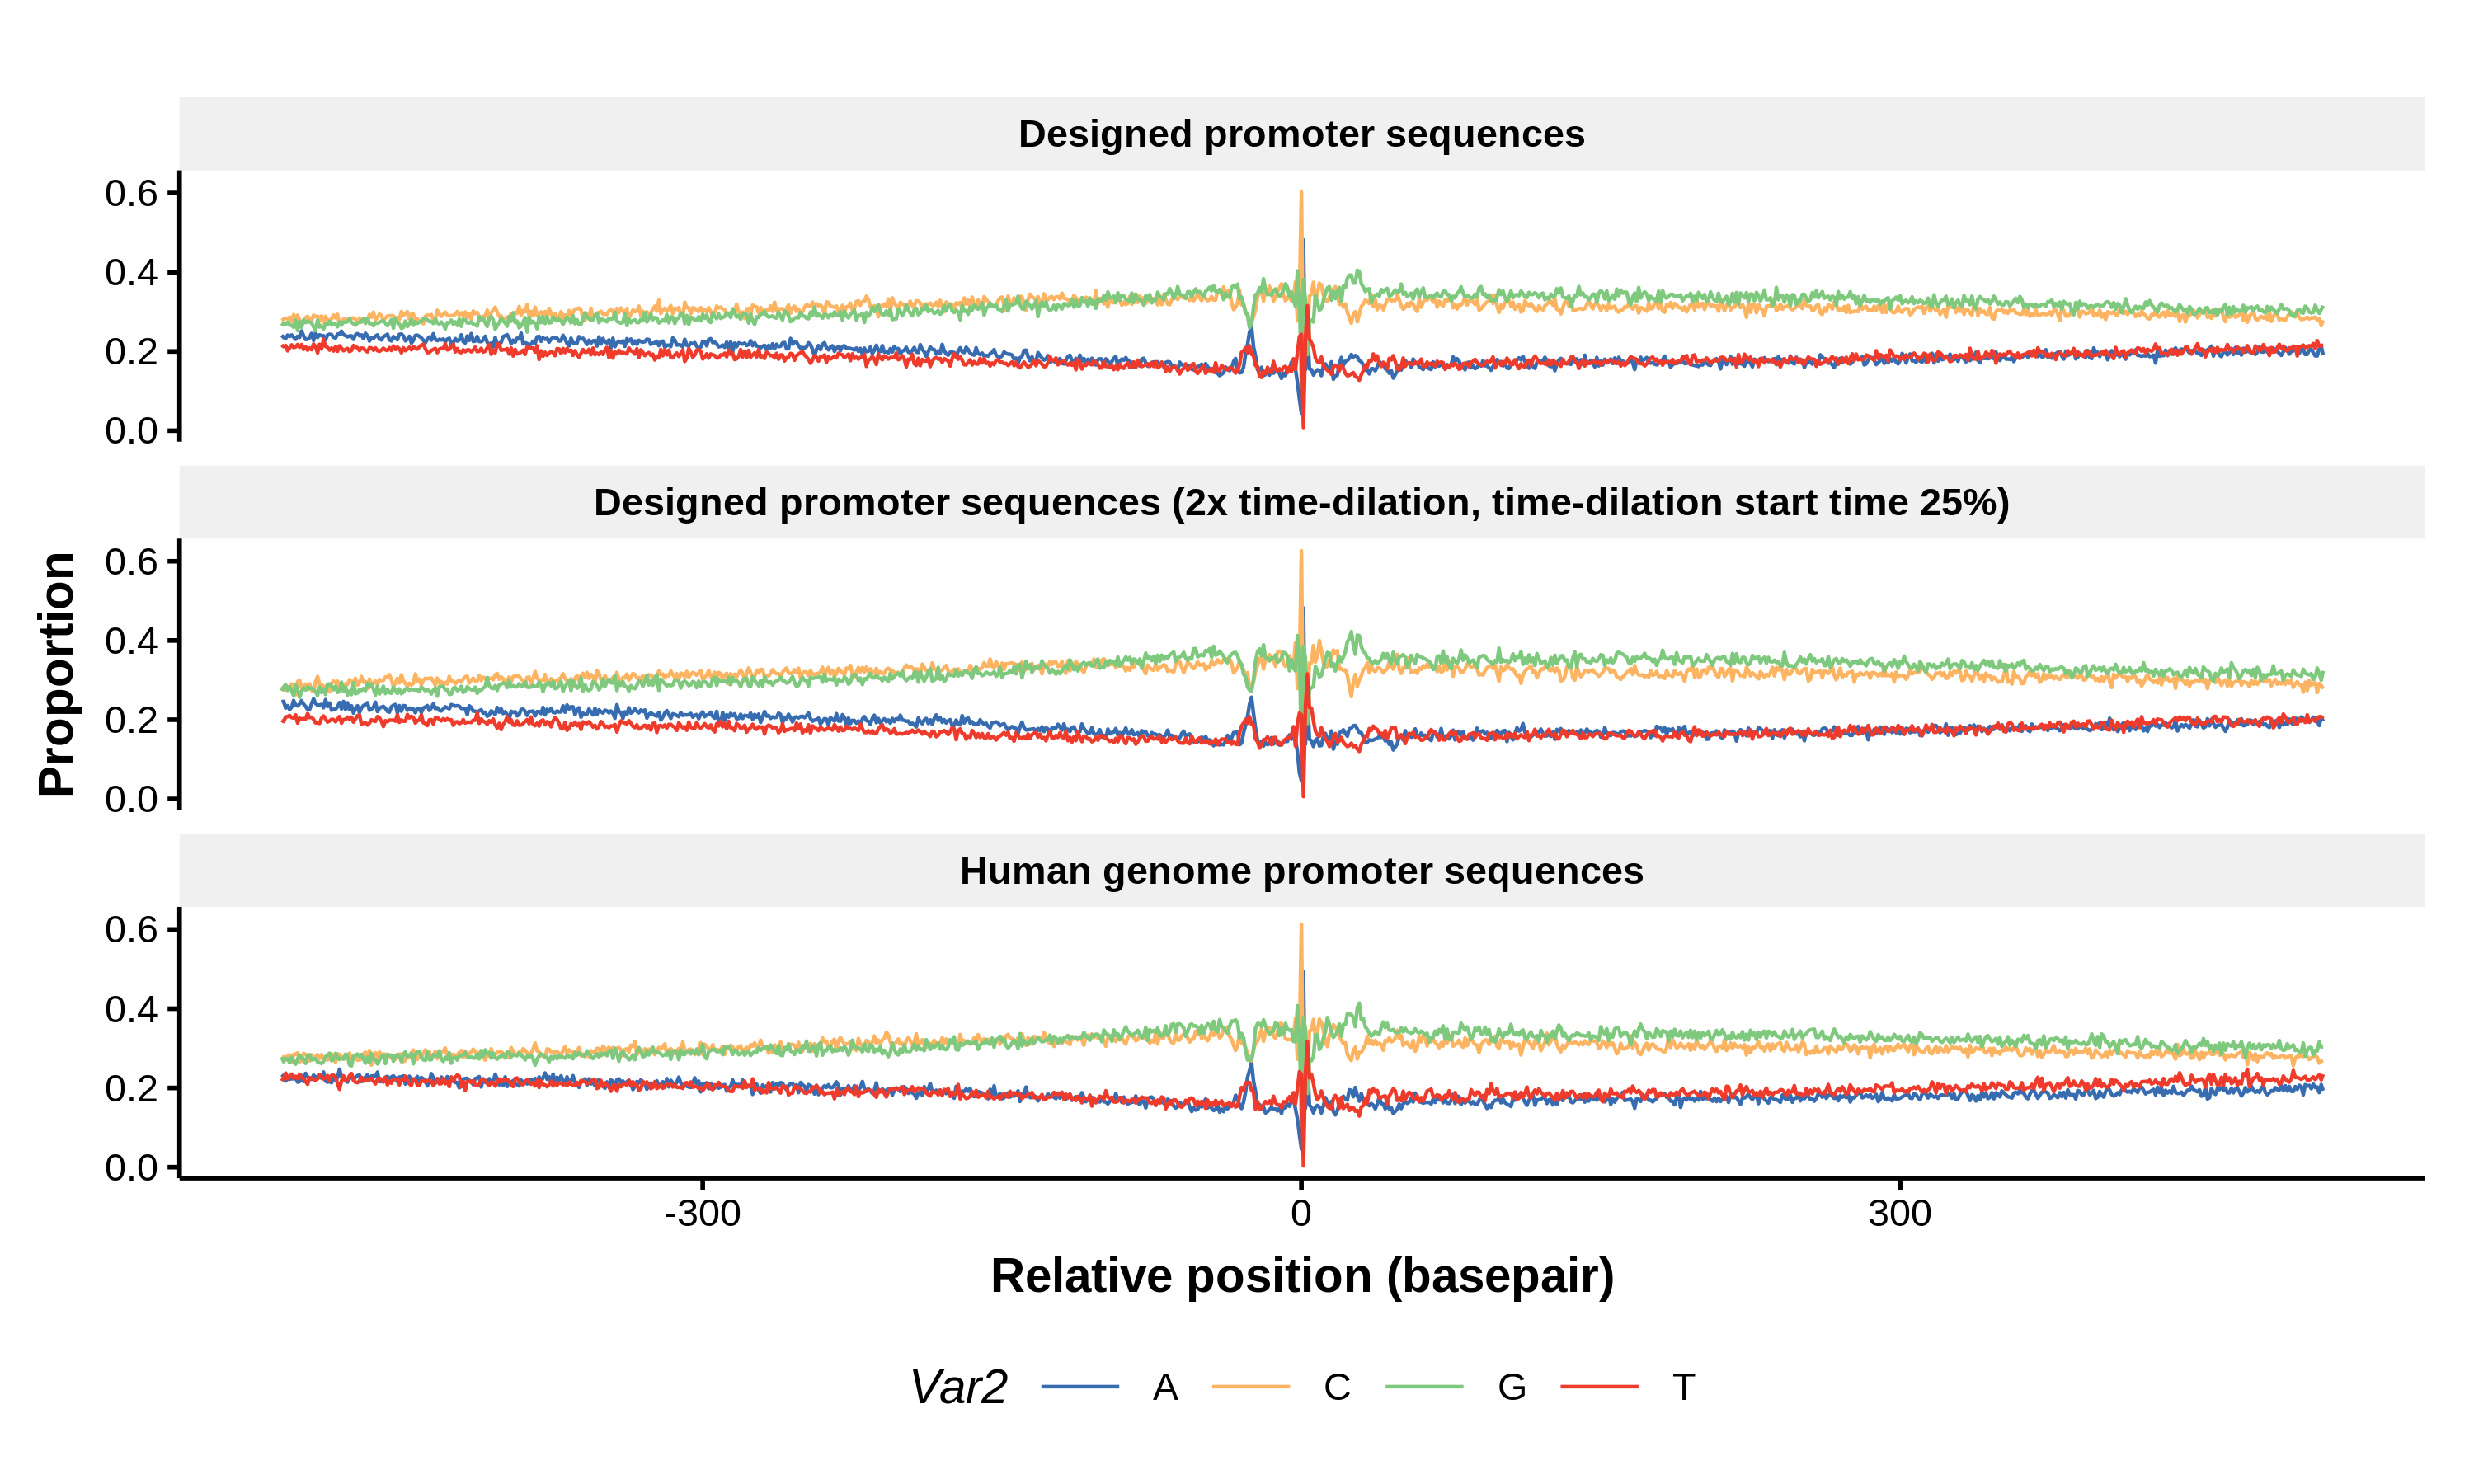

In [39]:
%%R -i sample_bp,sample_bp2x,testseqs_bp -w 10 -h 6 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp) = c('A','C','G','T')
colnames(sample_bp2x) = c('A','C','G','T')
colnames(testseqs_bp) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp),type='Designed promoter sequences'), 
                 cbind(melt(sample_bp2x),type='Designed promoter sequences (2x time-dilation, time-dilation start time 25%)'), 
                 cbind(melt(testseqs_bp),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=3)+xlab('Relative position (basepair)') + ylab('Proportion')

ggsave('./figures/seqs_bp2.pdf', device=cairo_pdf)
p

In [149]:
tsses = pd.read_table('/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/analysis/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v4.tsv', sep='\t')
tsses.iloc[np.isin(tsses['chr'], ['chr8','chr9']),:].iloc[:10,:]

Unnamed: 0   chr strand        TSS              geneID geneName  \
29          30  chr8      -   98045544   ENSG00000156482.6    RPL30   
30          31  chr9      -  124861956  ENSG00000136942.10    RPL35   
31          32  chr8      -   56074500   ENSG00000008988.5    RPS20   
32          33  chr8      -   56074505   ENSG00000008988.5    RPS20   
33          34  chr8      -   56074498   ENSG00000008988.5    RPS20   
54          57  chr8      -  100722086   ENSG00000070756.9   PABPC1   
57          60  chr8      -  144792389  ENSG00000161016.11     RPL8   
89          94  chr9      +  137241286   ENSG00000188229.5   TUBB4B   
93          98  chr9      -  125241342   ENSG00000044574.7    HSPA5   
96         101  chr9      -  136866307   ENSG00000107223.8     EDF1   

      geneClass geneCategory      DHS_type        geneType  ...  \
29  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
30  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
31  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
32  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
33  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
54  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
57  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
89  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
93  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
96  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   

   FANTOM_CAGE_scaled ENCODE_CAGE_scaled  ENCODE_RAMPAGE_scaled  \
29         2350.44530         105.612411             562.760532   
30         2306.81700        2148.146299            4972.591532   
31         2284.17970         135.766191             866.931950   
32         2283.99020         134.672000             865.594298   
33         2283.29690         138.533159             868.624564   
54         1616.27420         676.864568             131.442257   
57         1586.97160         278.008913            1561.383850   
89         1026.26930          35.958278             181.143199   
93          989.45386        1191.424906             553.153617   
96          956.87930         410.223650            1024.668599   

    GROCAP_K562_scaled  GROCAP_GM12878_scaled  Cor_ENCODE_CAGE  \
29          339.831321             343.097945         0.571092   
30           95.655495             136.014205         0.819336   
31          980.992480             702.986677         0.720898   
32          980.194520             700.346649         0.720899   
33          981.391460             702.141868         0.720897   
54          181.037241             109.930742         0.784758   
57          645.150811             781.553848         0.782889   
89          743.200127             609.951890         0.637029   
93           94.059564              82.791268         0.742167   
96           57.054158              44.563667         0.734052   

    Cor_ENCODE_RAMPAGE  Cor_GROCAP_K562  Cor_GROCAP_GM12878       Cor  
29            0.683992         0.746955            0.705151  0.670978  
30            0.708856         0.676118            0.590568  0.947734  
31            0.720818         0.742355            0.715826  0.820319  
32            0.720818         0.742355            0.715827  0.820319  
33            0.720818         0.742355            0.715826  0.820319  
54            0.664371         0.701319            0.708451  0.960123  
57            0.587857         0.843305            0.794617  0.988553  
89            0.666855         0.721713            0.683238  0.881568  
93            0.571000         0.633268            0.590952  0.948131  
96            0.642229         0.700645            0.692280  0.822692  

[10 rows x 28 columns]

In [80]:
net(valid_datasets[0][:,:,:4].transpose(1,2).cuda()).cpu().detach().numpy()[:,0,300:-300].mean()


0.057337362

In [547]:
samples = Euler_Maruyama_sampler(score_model, \
                          (1024,4), \
                          batch_size=test_datasets[0].shape[0], \
                                max_time= 4*2, \
                                min_time=4/400*2, \
                                time_dilation=0.5,\
                                num_steps=200, \
                                eps=1e-5, \
                          speed_balanced=speed_balanced,\
                          device=device, \
                          concat_input = test_datasets[0][:,:,4:5].cuda())

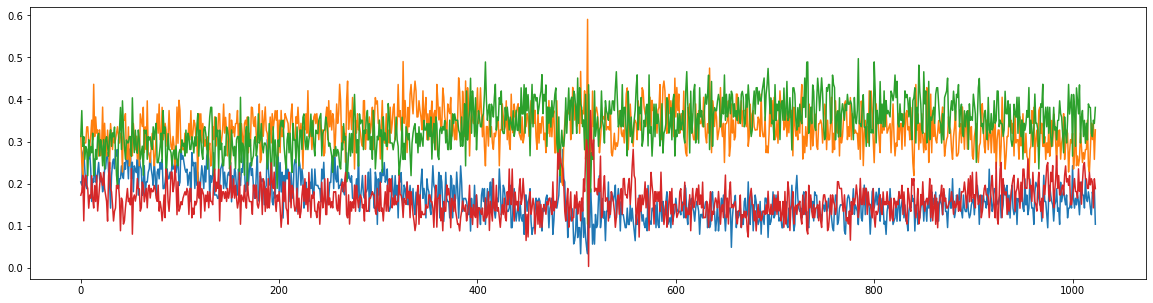

In [368]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(samples.cpu().detach().numpy().mean(axis=0))

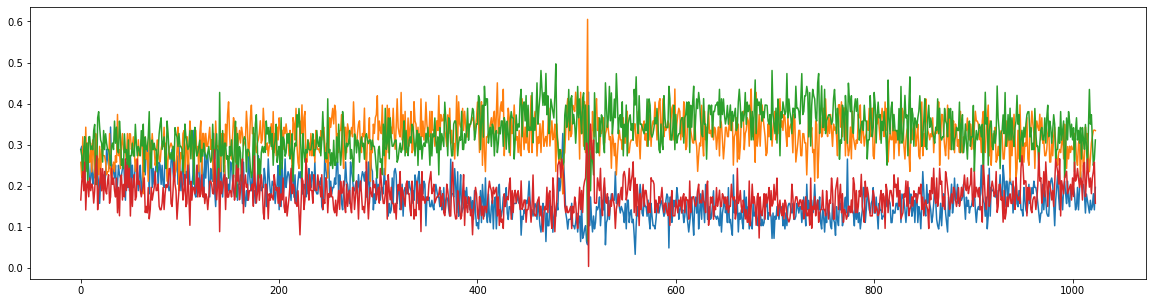

In [370]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(samples.cpu().detach().numpy().mean(axis=0))

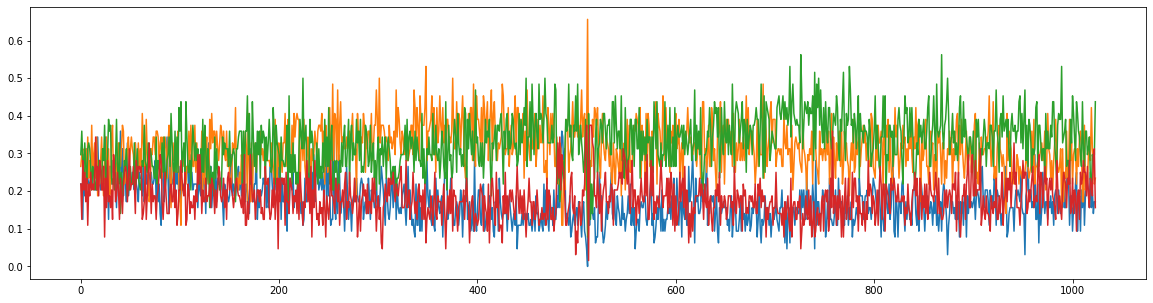

In [550]:
plt.figure(figsize=(20,5))
plt.plot(test_datasets[0][...,:4].cpu().detach().numpy().mean(axis=0))


In [ ]:
#load test set TSSes 
tsses = pd.read_table('/archive/bioinformatics/Zhou_lab/shared/jzhou/FANTOM/analysis/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v4.tsv', sep='\t')
tsses.iloc[np.isin(tsses['chr'], ['chr8','chr9']),:].iloc[:10,:]

In [155]:
tsses.iloc[np.isin(tsses['chr'], ['chr8','chr9']),:].iloc[[0,9,99,999],:]

Unnamed: 0   chr strand        TSS              geneID geneName  \
29             30  chr8      -   98045544   ENSG00000156482.6    RPL30   
96            101  chr9      -  136866307   ENSG00000107223.8     EDF1   
1608         1632  chr9      -  121201868   ENSG00000119396.6    RAB14   
13417       13571  chr9      -  135907522  ENSG00000130559.14  CAMSAP1   

         geneClass geneCategory      DHS_type        geneType  ...  \
29     coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
96     coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
1608   coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   
13417  coding_mRNA  coding_mRNA  DHS_promoter  protein_coding  ...   

      FANTOM_CAGE_scaled ENCODE_CAGE_scaled  ENCODE_RAMPAGE_scaled  \
29           2350.445300         105.612411             562.760532   
96            956.879300         410.223650            1024.668599   
1608          120.283195         144.200093              56.999906   
13417          10.129543           0.213172               0.000000   

       GROCAP_K562_scaled  GROCAP_GM12878_scaled  Cor_ENCODE_CAGE  \
29             339.831321             343.097945         0.571092   
96              57.054158              44.563667         0.734052   
1608             6.483427               9.715302         0.718344   
13417            0.000000               0.105601         0.524908   

       Cor_ENCODE_RAMPAGE  Cor_GROCAP_K562  Cor_GROCAP_GM12878       Cor  
29               0.683992         0.746955            0.705151  0.670978  
96               0.642229         0.700645            0.692280  0.822692  
1608             0.631888         0.543337            0.459467  0.765902  
13417            0.024387         0.221664            0.316976  0.629958  

[4 rows x 28 columns]

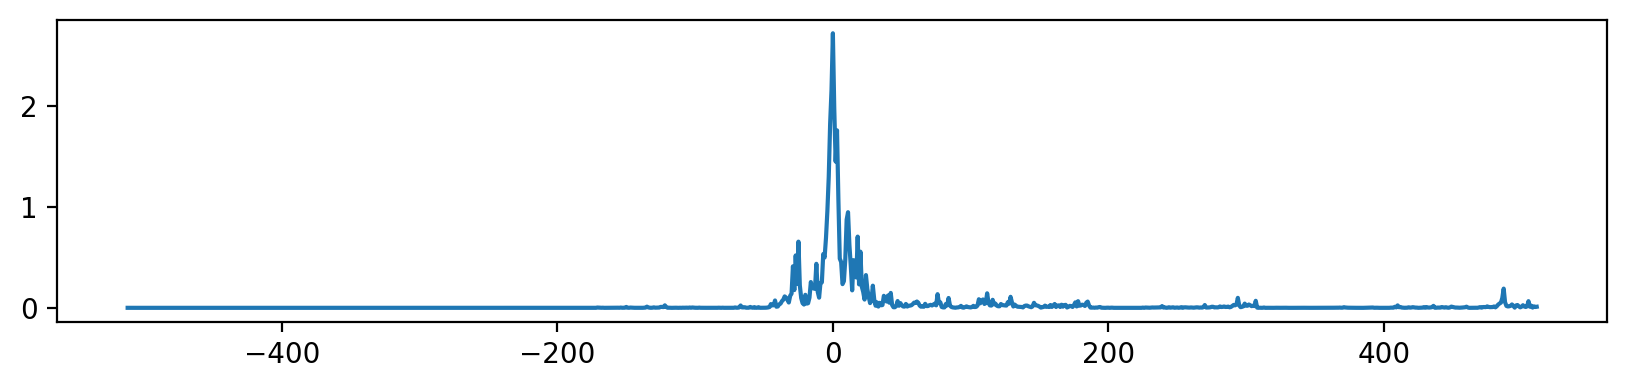

In [286]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(10,2), dpi=200)
plt.plot(np.arange(-512,512), test_datasets[0][8][...,4])
plt.savefig('./figures/example_transcription_signal.pdf')

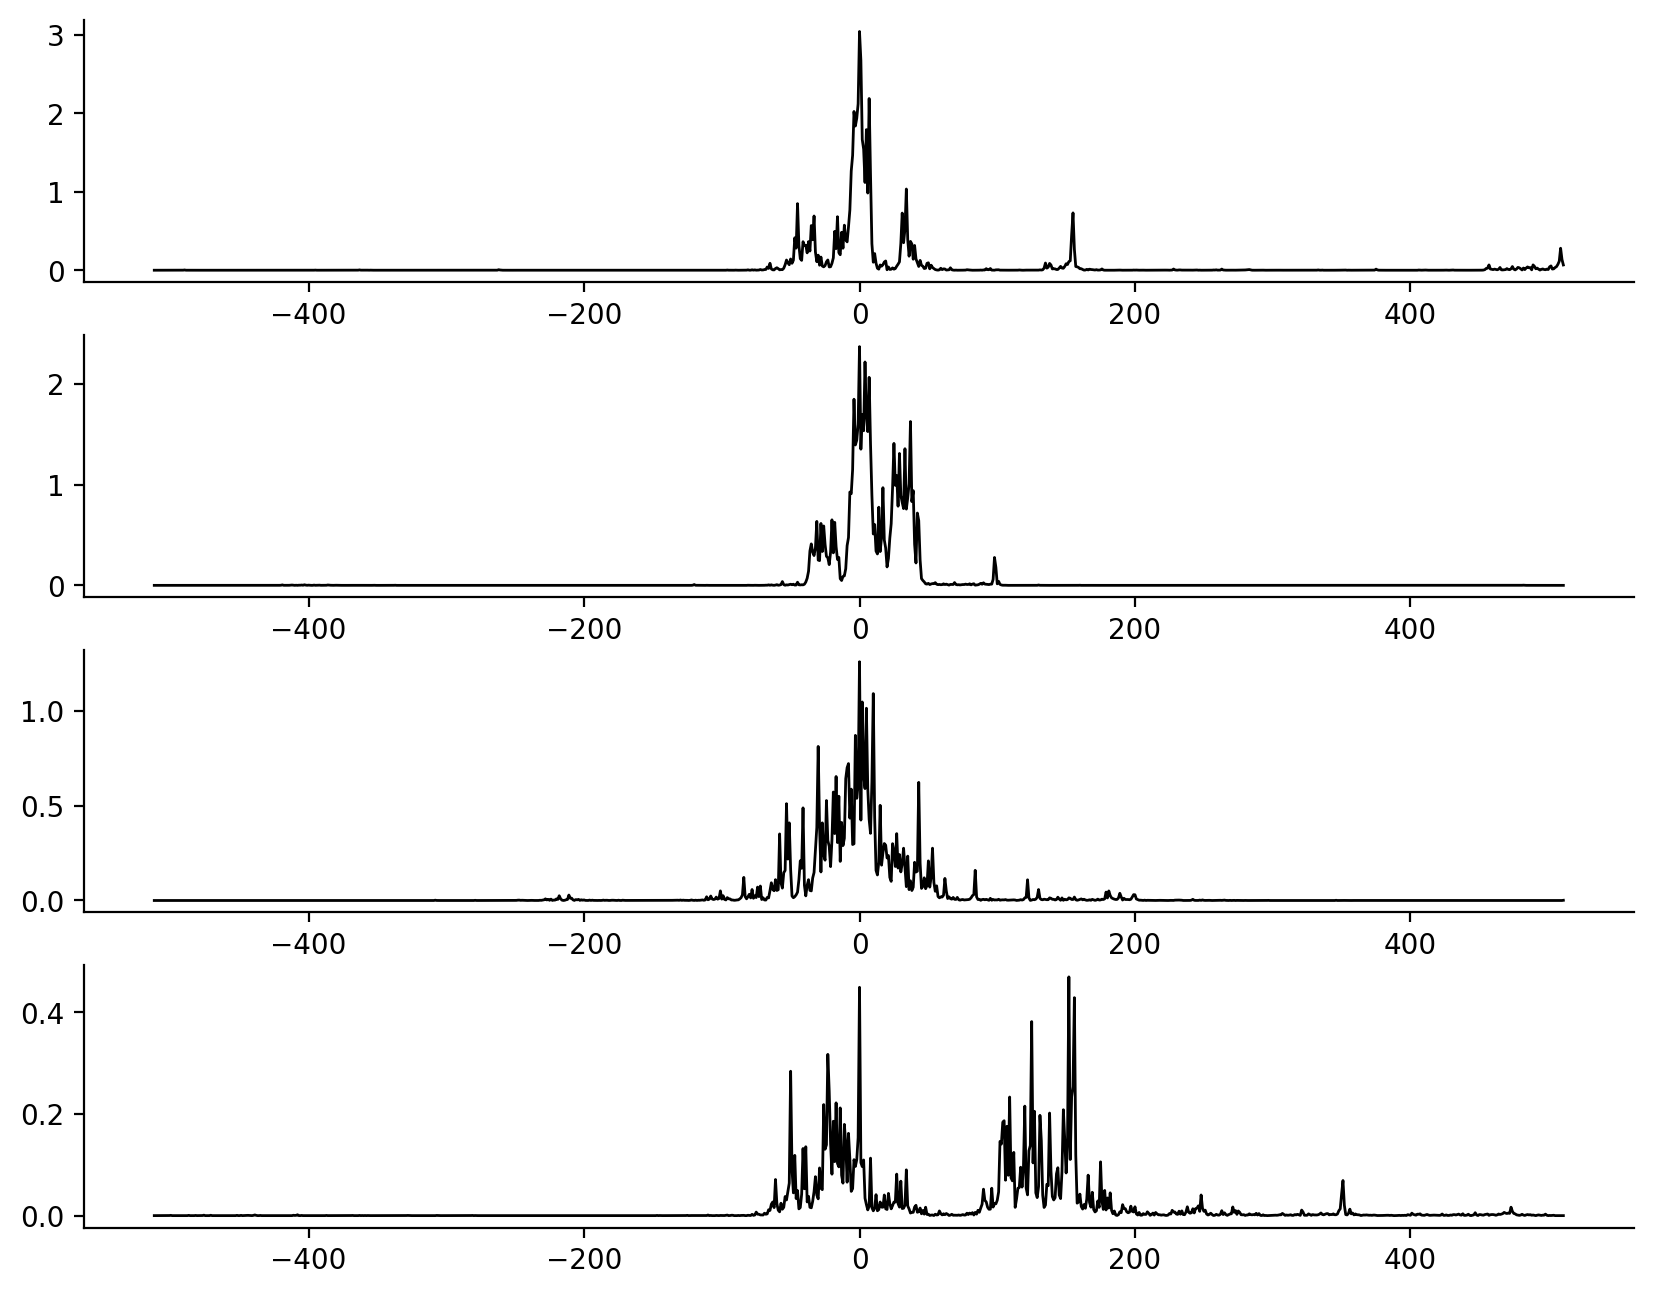

In [177]:
import seaborn
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
_, axes = plt.subplots(figsize=(10,8), nrows=4, dpi=200)
axes[0].plot(np.arange(-512,512), np.concatenate(test_datasets)[0,:,4], color='black', linewidth = 1)
axes[1].plot(np.arange(-512,512), np.concatenate(test_datasets)[9,:,4], color='black', linewidth = 1)
axes[2].plot(np.arange(-512,512), np.concatenate(test_datasets)[99,:,4], color='black', linewidth = 1)
axes[3].plot(np.arange(-512,512), np.concatenate(test_datasets)[999,:,4], color='black', linewidth = 1)
seaborn.despine()
plt.savefig('./figures/more_example_transcription_signal.pdf')

In [165]:
for i in [0,9,99,999]:
    print('>'+str(i)+' Human genome sequence')
    print(''.join(np.array(["A","C","G","T"])[testseqs[i].argmax(-1)].tolist()))


>0 Human genome sequence
GCTTAAAGGCCCGCAGAGGGGGAAAAGAACACCCCCGCCGTCATTCTTTTTTTTCCTTCTTTGAGACAGAGTCTCACTCTGTCGCCCAGGCTGAGTGCAGTGGCGCGATCATGGCTCACTGCAGCCTCGACCTACCGAGCTCAAGCGACCTCTCCGCCTCAGCCTCCGGCGTAGCTGGGAGTAGCTAGGACTACTGGAGCGCGCCACCACGCCCGGCTAATTTCTTTTTTATTTCTTTTTTATTTTTTTGTAGAGACAGGGGTGGTCTATGTTGTCCAGGCTGGCCTTGAGCTGGACGCAACAGATCTTCCCGCCTCAACCTCCGAAAGTGCTGGGATTAAAGGTATGAGCAGCCGCGTACGGCCCCCGCAGCCATTCTAGCTAGCGGTACCAATAGCAACCGGCAGCTGCCCTCCGCTTTTGCTCCGCCCCTTCTGCTTGCGATCTGTTTCCGCTTCCGGTCCCGCAGTTCCGGCTCTGCCGTGAAGAGCTTTGCATTGTGGGAAGTCTTTCCTTTCTCGTTCCCCGGCCATCTTAGCGGCTGCTGTTGGTGAGTGGGCTCCTACCGACCGAGGTTTAGGCAGCGCGGGGAGCTTTGCGGGTTGCCATTTGTAACTCCGGATCCTAAAATTCCTGTCCTGTTCTCTGTCTCTTCTAGGTTGGGGGCCGTCCCGCTCCTAAGGCAGGAAGATGGTGGCCGCAAAGAAGACGGTGAGTGAGGCGGGCCAGGCCCGGAAGACGATTCACGTGGAGAGATGTCTTGGCCAGGGCGGGCAGATGTGAGCCCACGGGGGTGACAGCATGCCTGCTGGCATTTGGAGGGCCCCAGAAGGAATCCCAGTGGCCCTCTCAATGACTTGGGGTCCTCGACTTCGGAAGTTTAAGGGGCTCGGCTTCAAAAAGCTGGGTCCGGTTTTGAGGCGGTTGCAGGCGAGGCCCTTAGGTCCGTATTTAATGTTTGCTTTGTAGAAAAAG

In [178]:
for i in [0,9,99,999]:
    for rep in range(5):
        print('>'+str(i) + ' ' + 'rep' + str(rep))
        print(''.join(np.array(["A","C","G","T"])[allsamples[rep][i].argmax(-1)].tolist()))

>0 rep0
AGCCAAGCTGCAGCATCCACCGGAGTCAGTACAAGGGCGCCATCCAGAAGGAACAAAGGCCCGGGGTCTGAGCCCCTACCCTGTTCCCTCCCCTCCACACTCCCCTTCTCTTTCCTCACTCCTTCACCCCTCCCCAAAGATAAAGCTTCAGTTTCCCACCAGTCCCCTAGAGCCTGCATCTTAAACGTGACCTCTCCCTGTCTGGACCTGGACCCTTCCCCTCTGTCGAACCTTTCAAAAGGGCCACCTTGAAGCGGGCGCAAGCAGAAGCCGGATAGCTACGACTCATGTCAGAAATAGAGAGTGAAAACAAATCCCATTACCCCAAGCCGCCCACGTTAAGATTCCTCCCCCTCAGCCACTGCCCCCGCTTCCCTAGACACCAATGGCCAGCCTGGGAGCGTCACCCTCTCCTCACTTTCAGAGGAACTGATATGTCCAATAGCTCTTTCCGGGCCAGGTCTCGCACTTCCGCTTCCGCTGTAAATGGCTTTGCAGCGTGCCAGCTCTTTCGTTTCTACGTCGCCGGCCATCTTGTCTGCTGTCATTGCTAAGTGAGGGGCTAAGATTCATGCTTCAATTATTTTGCTGGAGTTTCCAGGGCACCATTTGTAGCGTCGGCTCGGGGAATTACAGTACTGATGTTCCTGGGTAAACCGGACCTGGCGGTAGCAATTATAGAAACGTCGTTTCCTGAGCCCATTGCCGCAGGTGAGTAGACGGAATGCGAATCCTTTTCTGATCCGCCTGCGACGGCGCGGCCGGCTGGGCAGGGCGACGGCCGGGCTCCCCGGTGAGACGCCGCCGTCCGGCGTTCGCCAGCGGGCCTGACCCCTTGTCTTGGCGGTCTGAGCCACTTGGCCGCCTCTCAGGCTGTGGACCCCGGGCGTCAGCTCTGCATGCCGCTCTTAGCTTTTCCGTGCGTTGTGCAGGACTCCCTTAACAGCTCGCCATGGCCCGTCTCTCTGCACAGGGTCGGCCCGCTCGTTCCC

In [428]:
#likelihood computation

from scipy import integrate
def prior_likelihood(v, alpha, beta, device='cuda'):
    alpha = alpha.to(device)
    beta = beta.to(device)
    v = v.to(device)
    return beta_logp(alpha, beta, v).sum(dim=tuple(range(1, v.ndim)))

def ode_likelihood(v, 
                   score_model,
                   max_time=4,
                   min_time=1e-2,
                   time_dilation=1,
                   batch_size=64, 
                   device='cuda',
                   eps=1e-6,
                   alpha = None,
                   beta = None,
                   speed_balanced=True,
                   concat_input=None,
                   verbose=False):
  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
    shape = v.shape
    epsilon = torch.randn(shape).to(device)

    if alpha is None:
        alpha = torch.ones(shape[-1])
    if beta is None:
        beta = torch.arange(shape[-1], 0, -1, dtype=torch.float)
    alpha = alpha.to(device)
    beta = beta.to(device)
    if speed_balanced:
        s = 2. / (alpha + beta)
    else:
        s = torch.ones(shape[-1]).to(device)
    
    sb = UnitStickBreakingTransform()
    def logodds(v):
        return np.log( np.fmax(v, eps)/np.fmax(1-v, eps))
    def inverse_logodds(lov):
        return 1-1/(1+np.exp(lov))
    

    def divergence_eval_wrapper(sample, time_steps):
        #epsilon = torch.randn(shape).to(device)
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
        with torch.enable_grad():
            sample.requires_grad_(True)
            x = sb(sample)
            g = torch.sqrt(sample*(1-sample))
            logdet = sb.log_abs_det_jacobian(sample)
            gradlogdet = grad(logdet.sum(), sample, create_graph=True)[0]
            
            if concat_input is not None:
                score_x = score_model(torch.cat([x, concat_input], -1), time_steps*time_dilation)
            else:
                score_x = score_model(x, time_steps*time_dilation)
            score_v = grad(x,sample,score_x,create_graph=True)[0]-gradlogdet
            
            f_tilde = s[(None,)*(sample.ndim-1)]*(0.5*(alpha[(None,)*(sample.ndim-1)]*(1-sample)-beta[(None,)*(sample.ndim-1)]*sample) - \
                 0.5*(1-2*sample) -0.5 * (g**2) *(score_v))
            score_e = torch.sum( f_tilde* epsilon)
            grad_score_e = grad(score_e, sample)[0]
        div = torch.sum(grad_score_e * epsilon, dim= tuple(range(1, grad_score_e.ndim))).cpu().numpy().astype(np.float64)
        return div, f_tilde.cpu().detach().numpy().reshape((-1,)).astype(np.float64)
    
    def ode_func(t, ode_x):
        time_steps = np.ones((shape[0],)) * t 
        v = inverse_logodds(ode_x[:-shape[0]])
        logp = ode_x[-shape[0]:]
        logp_grad, f_tilde = divergence_eval_wrapper(v, time_steps) 
        sample_grad = f_tilde * (1/(np.fmax(v, eps))+1/np.fmax(1-v, eps))
        
        return np.concatenate([sample_grad, logp_grad], axis=0)
    

    init = np.concatenate([logodds(v.detach().cpu().numpy().reshape((-1,))), np.zeros((shape[0],))], axis=0)
    # Black-box ODE solver
    #res = integrate.solve_ivp(ode_func, (min_time, max_time), init, rtol=1e-5, atol=1e-5, method='RK45')  
    #faster
    #res = integrate.solve_ivp(ode_func, (min_time, max_time), init, rtol=1e-3, atol=1e-3, method='RK23')  
    res = integrate.solve_ivp(ode_func, (min_time, max_time), init, rtol=1e-4, atol=1e-4, method='RK23')  
    zp = res.y[:, -1]
    z = torch.Tensor(inverse_logodds(zp[:-shape[0]])).to(device).reshape(shape)
    
    delta_logp = torch.Tensor(zp[-shape[0]:]).to(device).reshape(shape[0])
    prior_logp = prior_likelihood(z, alpha, beta)
    sb_delta_logp = sb.log_abs_det_jacobian(v.to(device))
    if v.ndim-1 > 1:
        sb_delta_logp = sb_delta_logp.sum(dim=tuple(range(1,v.ndim-1)))
    
    print(f"Number of function evaluations: {res.nfev}")
    if verbose:
        print("prior_logp", prior_logp)
        print("delta_logp", delta_logp)
        print("sb_delta_logp", sb_delta_logp)

    return z, prior_logp + delta_logp + sb_delta_logp


In [401]:
import gc 
gc.collect()

test_set = TSSDatasetS(split='test',n_tsses=100000, rand_offset=0)
test_data_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
test_datasets = []
for x in test_data_loader:
    test_datasets.append(x)

In [416]:
score_model.cuda()
score_model.eval()

all_bpds = 0.
all_items = 0
min_time = 4/400
max_time = 4

sb = UnitStickBreakingTransform()

logliks = []
loglikxs = []
qlogs  = []

#try:
#for i in range(100):
    #x = torch.zeros((batch_size, C))
    #x[torch.arange(batch_size), torch.randint(0,C,(batch_size,))]=1
for _ in range(10):
    for x in test_datasets:
        s = x[...,4:5]
        x = x[...,:4]
        #x = binary_to_onehot(x).squeeze()
        #perturbed_x = sb(Jacobi_Euler_Maruyama_sampler(x[...,0].cpu()*1.0,alpha,beta,min_time,1000,device='cpu')[...,None])
        perturbed_x, _ = diffusion_factory(x.cpu(), torch.zeros(x.shape[0]).long(),  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
        #perturbed_x, _ = diffusion_fast_flatdirichlet(x.cpu(), min_time, v_one, v_one_loggrad)


        perturbed_x = perturbed_x.to(device)
        x = x.to(device)
        v = sb._inverse(x, prevent_nan=False)
        perturbed_v = sb._inverse(perturbed_x, prevent_nan=False)

        z, loglik = ode_likelihood(perturbed_v, score_model, eps=1e-8, min_time=min_time, max_time=max_time,
                    device=device, alpha=None,beta=None, concat_input=s.cuda()) 
        N = np.prod(x.shape[1:-1]) 
        loglik = loglik / N


        loglikx =   ( torch.log(torch.clip(perturbed_x, min=1e-8)) * (x==1)).sum(-1).mean(-1)

        torch.set_default_dtype(torch.float64)

        with torch.no_grad():
            qlog = jacobi_diffusion_density(v.double(), perturbed_v.double(), min_time, alpha.to(device), beta.to(device), order=1000).log()
        for i, (a,b) in enumerate(zip(alpha.to(device), beta.to(device))):
            B = Beta(a, b)
            nanmask = torch.isnan(qlog[...,i])
            qlog[..., i][nanmask] = B.log_prob(perturbed_v[...,i][nanmask].double())
        qlog = (qlog.sum(-1)+sb.log_abs_det_jacobian(perturbed_v)).float().mean(-1)

        #qlog and loglikx  does not depdend on the model, so this is presampled to speed things up
        #note this is only for this dataset and this setup
        #qlog = 13.751514 

        #p.log().sum().backward()   
        #qlog  = (jacobi_diffusion_density(x[...,0].cpu().double(), perturbed_x[...,0].double(), min_time, alpha.double(), beta.double(), order=1000)).log()
        #qlog = qlog.mean().float().to(device)
        torch.set_default_dtype(torch.float32)

        elbo = loglik + loglikx - qlog
        logliks.append(loglik.cpu().detach().numpy())
        loglikxs.append(loglikx.cpu().detach().numpy())
        qlogs.append(qlog.cpu().detach().numpy())


        #bpd = -elbo
        bpd = -(elbo.cpu().detach().numpy()) / np.log(2)
        all_bpds += bpd.sum()
        all_items += bpd.shape[0]
        print("Average bits: {:5f}".format(all_bpds / all_items))
        print("Average nats: {:5f}".format(all_bpds / all_items *  np.log(2)))
        if np.isnan(all_bpds):
            break
        #print(np.mean(logliks),np.mean(loglikxs),np.mean(qlogs))
    #except KeyboardInterrupt:
    #    # Remove the error message when interuptted by keyboard or GUI.
    #    pass
    #variational lowerbound elbo with fixed q being defined by forward diffusion


Number of function evaluations: 197
Average bits: 1.319615
Average nats: 0.914687
Number of function evaluations: 191
Average bits: 1.310732
Average nats: 0.908531
Number of function evaluations: 191
Average bits: 1.260843
Average nats: 0.873949
Number of function evaluations: 188
Average bits: 1.267769
Average nats: 0.878750
Number of function evaluations: 188
Average bits: 1.287236
Average nats: 0.892244
Number of function evaluations: 185
Average bits: 1.286099
Average nats: 0.891456
Number of function evaluations: 188
Average bits: 1.291027
Average nats: 0.894872
Number of function evaluations: 185
Average bits: 1.294706
Average nats: 0.897422
Number of function evaluations: 185
Average bits: 1.304738
Average nats: 0.904376
Number of function evaluations: 185
Average bits: 1.307925
Average nats: 0.906585
Number of function evaluations: 188
Average bits: 1.312449
Average nats: 0.909720
Number of function evaluations: 185
Average bits: 1.317308
Average nats: 0.913088
Number of functi

Number of function evaluations: 179
Average bits: 1.460354
Average nats: 1.012240
Number of function evaluations: 179
Average bits: 1.460819
Average nats: 1.012563
Number of function evaluations: 182
Average bits: 1.462617
Average nats: 1.013809
Number of function evaluations: 179
Average bits: 1.464079
Average nats: 1.014822
Number of function evaluations: 182
Average bits: 1.465170
Average nats: 1.015579
Number of function evaluations: 176
Average bits: 1.467080
Average nats: 1.016902
Number of function evaluations: 182
Average bits: 1.467958
Average nats: 1.017511
Number of function evaluations: 176
Average bits: 1.469787
Average nats: 1.018779
Number of function evaluations: 182
Average bits: 1.470960
Average nats: 1.019592
Number of function evaluations: 179
Average bits: 1.471400
Average nats: 1.019897
Number of function evaluations: 182
Average bits: 1.472158
Average nats: 1.020422
Number of function evaluations: 179
Average bits: 1.473406
Average nats: 1.021287
Number of functi

Number of function evaluations: 182
Average bits: 1.461779
Average nats: 1.013228
Number of function evaluations: 176
Average bits: 1.461923
Average nats: 1.013328
Number of function evaluations: 185
Average bits: 1.462415
Average nats: 1.013669
Number of function evaluations: 179
Average bits: 1.463060
Average nats: 1.014116
Number of function evaluations: 179
Average bits: 1.463698
Average nats: 1.014558
Number of function evaluations: 185
Average bits: 1.463946
Average nats: 1.014730
Number of function evaluations: 182
Average bits: 1.463881
Average nats: 1.014685
Number of function evaluations: 179
Average bits: 1.464778
Average nats: 1.015307
Number of function evaluations: 179
Average bits: 1.465310
Average nats: 1.015676
Number of function evaluations: 179
Average bits: 1.465717
Average nats: 1.015958
Number of function evaluations: 182
Average bits: 1.466275
Average nats: 1.016344
Number of function evaluations: 185
Average bits: 1.466613
Average nats: 1.016579
Number of functi

Number of function evaluations: 176
Average bits: 1.464324
Average nats: 1.014992
Number of function evaluations: 176
Average bits: 1.464580
Average nats: 1.015169
Number of function evaluations: 176
Average bits: 1.464626
Average nats: 1.015201
Number of function evaluations: 176
Average bits: 1.464395
Average nats: 1.015041
Number of function evaluations: 173
Average bits: 1.464457
Average nats: 1.015084
Number of function evaluations: 179
Average bits: 1.464746
Average nats: 1.015284
Number of function evaluations: 179
Average bits: 1.464994
Average nats: 1.015456
Number of function evaluations: 179
Average bits: 1.465292
Average nats: 1.015663
Number of function evaluations: 179
Average bits: 1.465727
Average nats: 1.015965
Number of function evaluations: 179
Average bits: 1.465902
Average nats: 1.016086
Number of function evaluations: 179
Average bits: 1.466167
Average nats: 1.016269
Number of function evaluations: 176
Average bits: 1.466744
Average nats: 1.016669
Number of functi

Number of function evaluations: 182
Average bits: 1.465722
Average nats: 1.015961
Number of function evaluations: 182
Average bits: 1.465897
Average nats: 1.016082
Number of function evaluations: 176
Average bits: 1.465809
Average nats: 1.016021
Number of function evaluations: 179
Average bits: 1.465883
Average nats: 1.016073
Number of function evaluations: 173
Average bits: 1.465772
Average nats: 1.015996
Number of function evaluations: 182
Average bits: 1.465864
Average nats: 1.016059
Number of function evaluations: 176
Average bits: 1.465798
Average nats: 1.016014
Number of function evaluations: 176
Average bits: 1.465557
Average nats: 1.015847
Number of function evaluations: 179
Average bits: 1.465709
Average nats: 1.015952
Number of function evaluations: 179
Average bits: 1.465814
Average nats: 1.016025
Number of function evaluations: 173
Average bits: 1.465760
Average nats: 1.015987
Number of function evaluations: 179
Average bits: 1.465779
Average nats: 1.016001
Number of functi

Number of function evaluations: 185
Average bits: 1.468156
Average nats: 1.017648
Number of function evaluations: 182
Average bits: 1.468041
Average nats: 1.017568
Number of function evaluations: 185
Average bits: 1.467897
Average nats: 1.017469
Number of function evaluations: 185
Average bits: 1.468026
Average nats: 1.017558
Number of function evaluations: 188
Average bits: 1.467900
Average nats: 1.017471
Number of function evaluations: 182
Average bits: 1.467965
Average nats: 1.017516
Number of function evaluations: 185
Average bits: 1.467782
Average nats: 1.017389
Number of function evaluations: 182
Average bits: 1.467766
Average nats: 1.017378
Number of function evaluations: 188
Average bits: 1.467597
Average nats: 1.017261
Number of function evaluations: 176
Average bits: 1.467519
Average nats: 1.017207
Number of function evaluations: 179
Average bits: 1.467662
Average nats: 1.017306
Number of function evaluations: 179
Average bits: 1.467578
Average nats: 1.017247
Number of functi

Number of function evaluations: 188
Average bits: 1.473575
Average nats: 1.021404
Number of function evaluations: 188
Average bits: 1.473424
Average nats: 1.021299
Number of function evaluations: 185
Average bits: 1.473221
Average nats: 1.021159
Number of function evaluations: 188
Average bits: 1.472945
Average nats: 1.020968
Number of function evaluations: 185
Average bits: 1.472760
Average nats: 1.020839
Number of function evaluations: 185
Average bits: 1.472363
Average nats: 1.020564
Number of function evaluations: 188
Average bits: 1.472237
Average nats: 1.020477
Number of function evaluations: 185
Average bits: 1.471873
Average nats: 1.020224
Number of function evaluations: 185
Average bits: 1.471793
Average nats: 1.020169
Number of function evaluations: 185
Average bits: 1.471694
Average nats: 1.020101
Number of function evaluations: 188
Average bits: 1.471286
Average nats: 1.019818
Number of function evaluations: 185
Average bits: 1.470995
Average nats: 1.019616
Number of functi

Number of function evaluations: 179
Average bits: 1.476186
Average nats: 1.023214
Number of function evaluations: 179
Average bits: 1.476325
Average nats: 1.023310
Number of function evaluations: 176
Average bits: 1.476547
Average nats: 1.023464
Number of function evaluations: 179
Average bits: 1.476764
Average nats: 1.023615
Number of function evaluations: 185
Average bits: 1.476917
Average nats: 1.023721
Number of function evaluations: 182
Average bits: 1.477198
Average nats: 1.023915
Number of function evaluations: 176
Average bits: 1.477354
Average nats: 1.024024
Number of function evaluations: 173
Average bits: 1.477356
Average nats: 1.024025
Number of function evaluations: 197
Average bits: 1.477022
Average nats: 1.023793
Number of function evaluations: 191
Average bits: 1.476795
Average nats: 1.023636
Number of function evaluations: 191
Average bits: 1.476487
Average nats: 1.023423
Number of function evaluations: 191
Average bits: 1.476336
Average nats: 1.023318
Number of functi

Number of function evaluations: 179
Average bits: 1.473477
Average nats: 1.021337
Number of function evaluations: 185
Average bits: 1.473549
Average nats: 1.021386
Number of function evaluations: 179
Average bits: 1.473688
Average nats: 1.021483
Number of function evaluations: 179
Average bits: 1.473863
Average nats: 1.021604
Number of function evaluations: 182
Average bits: 1.473967
Average nats: 1.021676
Number of function evaluations: 185
Average bits: 1.474066
Average nats: 1.021745
Number of function evaluations: 179
Average bits: 1.474122
Average nats: 1.021784
Number of function evaluations: 179
Average bits: 1.474265
Average nats: 1.021883
Number of function evaluations: 179
Average bits: 1.474475
Average nats: 1.022028
Number of function evaluations: 182
Average bits: 1.474544
Average nats: 1.022076
Number of function evaluations: 176
Average bits: 1.474691
Average nats: 1.022178
Number of function evaluations: 179
Average bits: 1.474872
Average nats: 1.022303
Number of functi

Number of function evaluations: 176
Average bits: 1.472056
Average nats: 1.020351
Number of function evaluations: 173
Average bits: 1.472196
Average nats: 1.020449
Number of function evaluations: 179
Average bits: 1.472189
Average nats: 1.020444
Number of function evaluations: 176
Average bits: 1.472250
Average nats: 1.020486
Number of function evaluations: 182
Average bits: 1.472299
Average nats: 1.020520
Number of function evaluations: 179
Average bits: 1.472226
Average nats: 1.020469
Number of function evaluations: 182
Average bits: 1.472306
Average nats: 1.020525
Number of function evaluations: 176
Average bits: 1.472346
Average nats: 1.020552
Number of function evaluations: 176
Average bits: 1.472293
Average nats: 1.020516
Number of function evaluations: 179
Average bits: 1.472403
Average nats: 1.020592
Number of function evaluations: 182
Average bits: 1.472537
Average nats: 1.020685
Number of function evaluations: 179
Average bits: 1.472602
Average nats: 1.020730
Number of functi

Number of function evaluations: 173
Average bits: 1.470382
Average nats: 1.019191
Number of function evaluations: 176
Average bits: 1.470385
Average nats: 1.019193
Number of function evaluations: 173
Average bits: 1.470378
Average nats: 1.019188
Number of function evaluations: 176
Average bits: 1.470418
Average nats: 1.019216
Number of function evaluations: 173
Average bits: 1.470524
Average nats: 1.019290
Number of function evaluations: 176
Average bits: 1.470552
Average nats: 1.019309
Number of function evaluations: 176
Average bits: 1.470621
Average nats: 1.019357
Number of function evaluations: 176
Average bits: 1.470654
Average nats: 1.019380
Number of function evaluations: 179
Average bits: 1.470680
Average nats: 1.019398
Number of function evaluations: 173
Average bits: 1.470681
Average nats: 1.019399
Number of function evaluations: 179
Average bits: 1.470717
Average nats: 1.019423
Number of function evaluations: 179
Average bits: 1.470787
Average nats: 1.019472
Number of functi

Number of function evaluations: 179
Average bits: 1.470987
Average nats: 1.019611
Number of function evaluations: 179
Average bits: 1.471014
Average nats: 1.019629
Number of function evaluations: 182
Average bits: 1.471006
Average nats: 1.019623
Number of function evaluations: 176
Average bits: 1.470973
Average nats: 1.019601
Number of function evaluations: 176
Average bits: 1.471076
Average nats: 1.019672
Number of function evaluations: 176
Average bits: 1.470978
Average nats: 1.019604
Number of function evaluations: 176
Average bits: 1.471001
Average nats: 1.019620
Number of function evaluations: 182
Average bits: 1.470918
Average nats: 1.019563
Number of function evaluations: 179
Average bits: 1.470896
Average nats: 1.019547
Number of function evaluations: 179
Average bits: 1.470871
Average nats: 1.019530
Number of function evaluations: 179
Average bits: 1.470860
Average nats: 1.019522
Number of function evaluations: 182
Average bits: 1.470868
Average nats: 1.019528
Number of functi

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



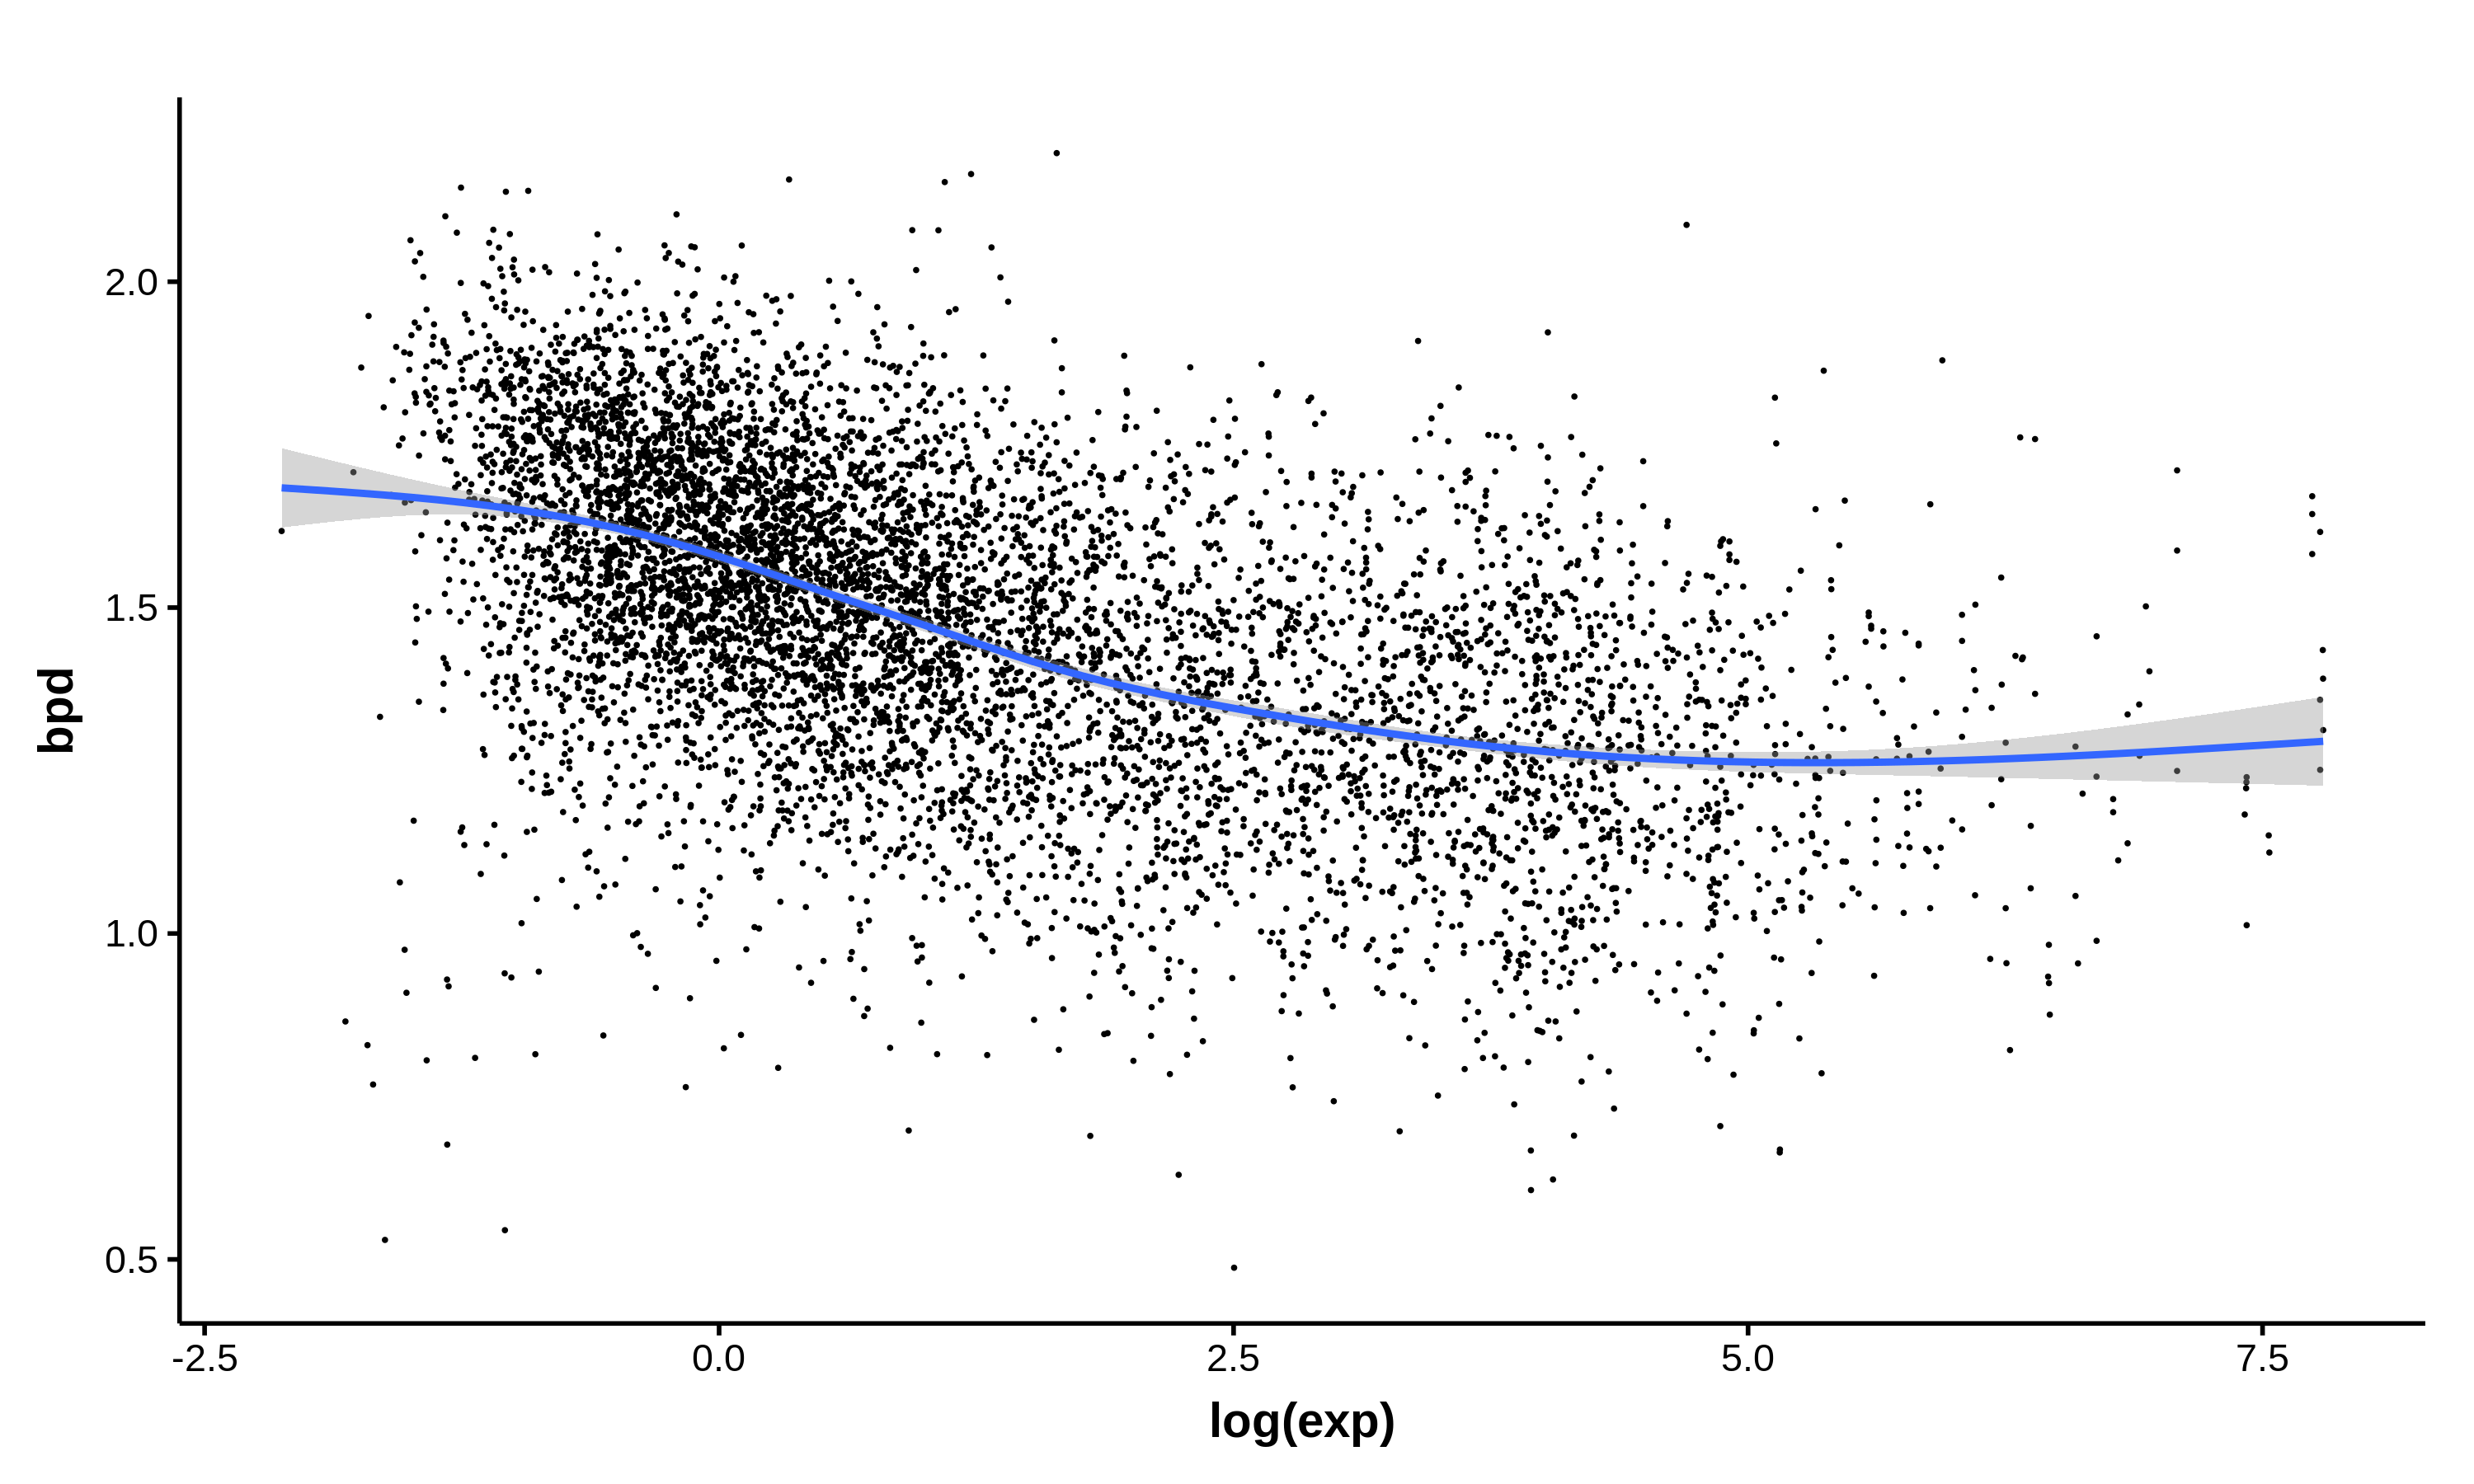

In [471]:
%%R -i exp,bpd  -w 10 -h 6 --unit in --res 300

qplot(log(exp),bpd, size=I(0.2))+geom_smooth()+theme_Publication()

In [483]:
%%R -i exp,bpd  -w 7.5 -h 4 --unit in --res 300
cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}
qplot(cutp(exp),bpd, geom='boxplot', notch=T, outlier.shape=NA)+
    theme_Publication()+ylab('NLL (bits per dimension)')+xlab('Promoter expression level (percentile)')
ggsave('./figures/seqs_nll.pdf', device=cairo_pdf)


R[write to console]: Saving 7.5 x 4 in image



In [40]:
import glob
import pandas as pd
import numpy as np
import torch
motifmeta = pd.read_table('/archive/bioinformatics/Zhou_lab/shared/jzhou/datasets/vierstra_2020_motif/v2/metadata.tsv')
from Bio.motifs import minimal
with open('/archive/bioinformatics/Zhou_lab/shared/jzhou/datasets/vierstra_2020_motif/v2/consensus_pwms.meme') as f:
    record = minimal.read(f)
motifs=[]
for motif in record:
    motifs.append(motif)

    
motifname = [m.name for m in motifs]
motifid = [m.split(':')[0] for m in motifname]
motifseq = {m.name: m.consensus for m in motifs}
motifpwm = {m.name: m.pwm for m in motifs}
motifkernels=[]
for i in range(len(motifname)):
    pmat = np.vstack([ motifpwm[motifname[i]][b] for b in ['A','C','G','T']]) 
    motifkernels.append( np.log2((pmat+ 0.01) / (np.array([0.295,0.205,0.205,0.295])[:,None]+ 0.01)))
motifkernelmat = np.zeros( (len(motifname), 29, 4))

for i in range(len(motifname)):
    k = motifkernels[i]
    starti = np.round((29 - k.shape[1])/2.0).astype(int)
    motifkernelmat[i, starti : starti+k.shape[1]]=k.T
motifkernelmat_cuda = torch.FloatTensor(motifkernelmat).cuda().permute(0,2,1)
motifkernelmat_rc_cuda = torch.FloatTensor(motifkernelmat[:,::-1,::-1].copy()).cuda().permute(0,2,1)

filtered = motifmeta['cluster'].value_counts()>3
filtered = filtered[filtered==True].index.values
motifkernelmat_cuda=motifkernelmat_cuda[np.isin(np.array(motifid), filtered),...]
motifkernelmat_rc_cuda=motifkernelmat_rc_cuda[np.isin(np.array(motifid), filtered),...]
motifname_filtered= np.array(motifname)[np.isin(np.array(motifid), filtered)]

In [45]:
motifname_filtered.tolist().index( 'AC0057:TBP/ZNF:TBP'),motifname_filtered.tolist().index('AC0524:KLF/SP:C2H2_ZF'), motifname_filtered.tolist().index('AC0240:NFYA/NFYB:CBF/NF-Y')


(30, 176, 98)

In [42]:
motifkernelmat_cuda_sub = motifkernelmat_cuda[[30,176,98]]

In [25]:
allsamples = np.load('./allsamples.npy')

In [43]:
samples_motifmatch = torch.nn.functional.conv1d(torch.FloatTensor(1*(allsamples[:,:,:,:].reshape(allsamples.shape[0]*allsamples.shape[1],allsamples.shape[2],allsamples.shape[3])>0.5)).transpose(1,2).cuda(), motifkernelmat_cuda_sub[:,:,:],padding=12).cpu().detach().numpy()

In [379]:
xs = []
ys = []
ms = []
ts = []
for i in range(6):
    samples_motifmatch = torch.nn.functional.conv1d((1.*torch.FloatTensor((allmultisamples[:3]+allmultisamples2[:3])[i][:,:,:]>0.5)).transpose(1,2).cuda(), motifkernelmat_cuda_sub[:,:,:],padding=12).cpu().detach().numpy()
    s0=np.reshape((samples_motifmatch[:,0,:]>8).mean(axis=0),(102,10)).sum(-1)
    s1=np.reshape((samples_motifmatch[:,1,:]>8).mean(axis=0),(102,10)).sum(-1)
    s2=np.reshape((samples_motifmatch[:,2,:]>7).mean(axis=0),(102,10)).sum(-1)

    
    xs.append(np.arange(-505,505+10,10))
    ys.append(s0)
    ms.append(np.repeat('TATA-box',102))
    xs.append(np.arange(-505,505+10,10))
    ys.append(s1)
    ms.append(np.repeat('GC-box',102))
    xs.append(np.arange(-505,505+10,10))
    ys.append(s2)
    ms.append(np.repeat('CCAAT-box',102))
    ts.append(np.repeat(i,102*3))
plotdata = pd.DataFrame(dict(x=np.concatenate(xs), 
                             y=np.concatenate(ys), 
                             motifs=np.concatenate(ms),
                             tsses = np.concatenate(ts) ))



In [44]:
samples_motifmatch2x = torch.nn.functional.conv1d(torch.FloatTensor(1*(allsamples2x[:,:2915,:,:].reshape(allsamples.shape[0]*allsamples.shape[1],allsamples.shape[2],allsamples.shape[3])>0.5)).transpose(1,2).cuda(), motifkernelmat_cuda_sub[:,:,:],padding=12).cpu().detach().numpy()


In [48]:
testseqs_motifmatch = torch.nn.functional.conv1d(torch.FloatTensor(testseqs).transpose(1,2).cuda(), motifkernelmat_cuda_sub[:,:,:],padding=12).cpu().detach().numpy()


In [46]:
s0=np.reshape((samples_motifmatch[:,0,:]>8).mean(axis=0),(102,10)).sum(-1)
s1=np.reshape((samples_motifmatch[:,1,:]>8).mean(axis=0),(102,10)).sum(-1)
s2=np.reshape((samples_motifmatch[:,2,:]>7).mean(axis=0),(102,10)).sum(-1)


In [45]:
s02=np.reshape((samples_motifmatch2x[:,0,:]>8).mean(axis=0),(102,10)).sum(-1)
s12=np.reshape((samples_motifmatch2x[:,1,:]>8).mean(axis=0),(102,10)).sum(-1)
s22=np.reshape((samples_motifmatch2x[:,2,:]>7).mean(axis=0),(102,10)).sum(-1)


In [49]:
d0=np.reshape((testseqs_motifmatch[:,0,:]>8).mean(axis=0),(102,10)).sum(-1)
d1=np.reshape((testseqs_motifmatch[:,1,:]>8).mean(axis=0),(102,10)).sum(-1)
d2=np.reshape((testseqs_motifmatch[:,2,:]>7).mean(axis=0),(102,10)).sum(-1)


R[write to console]: Saving 10 x 6 in image



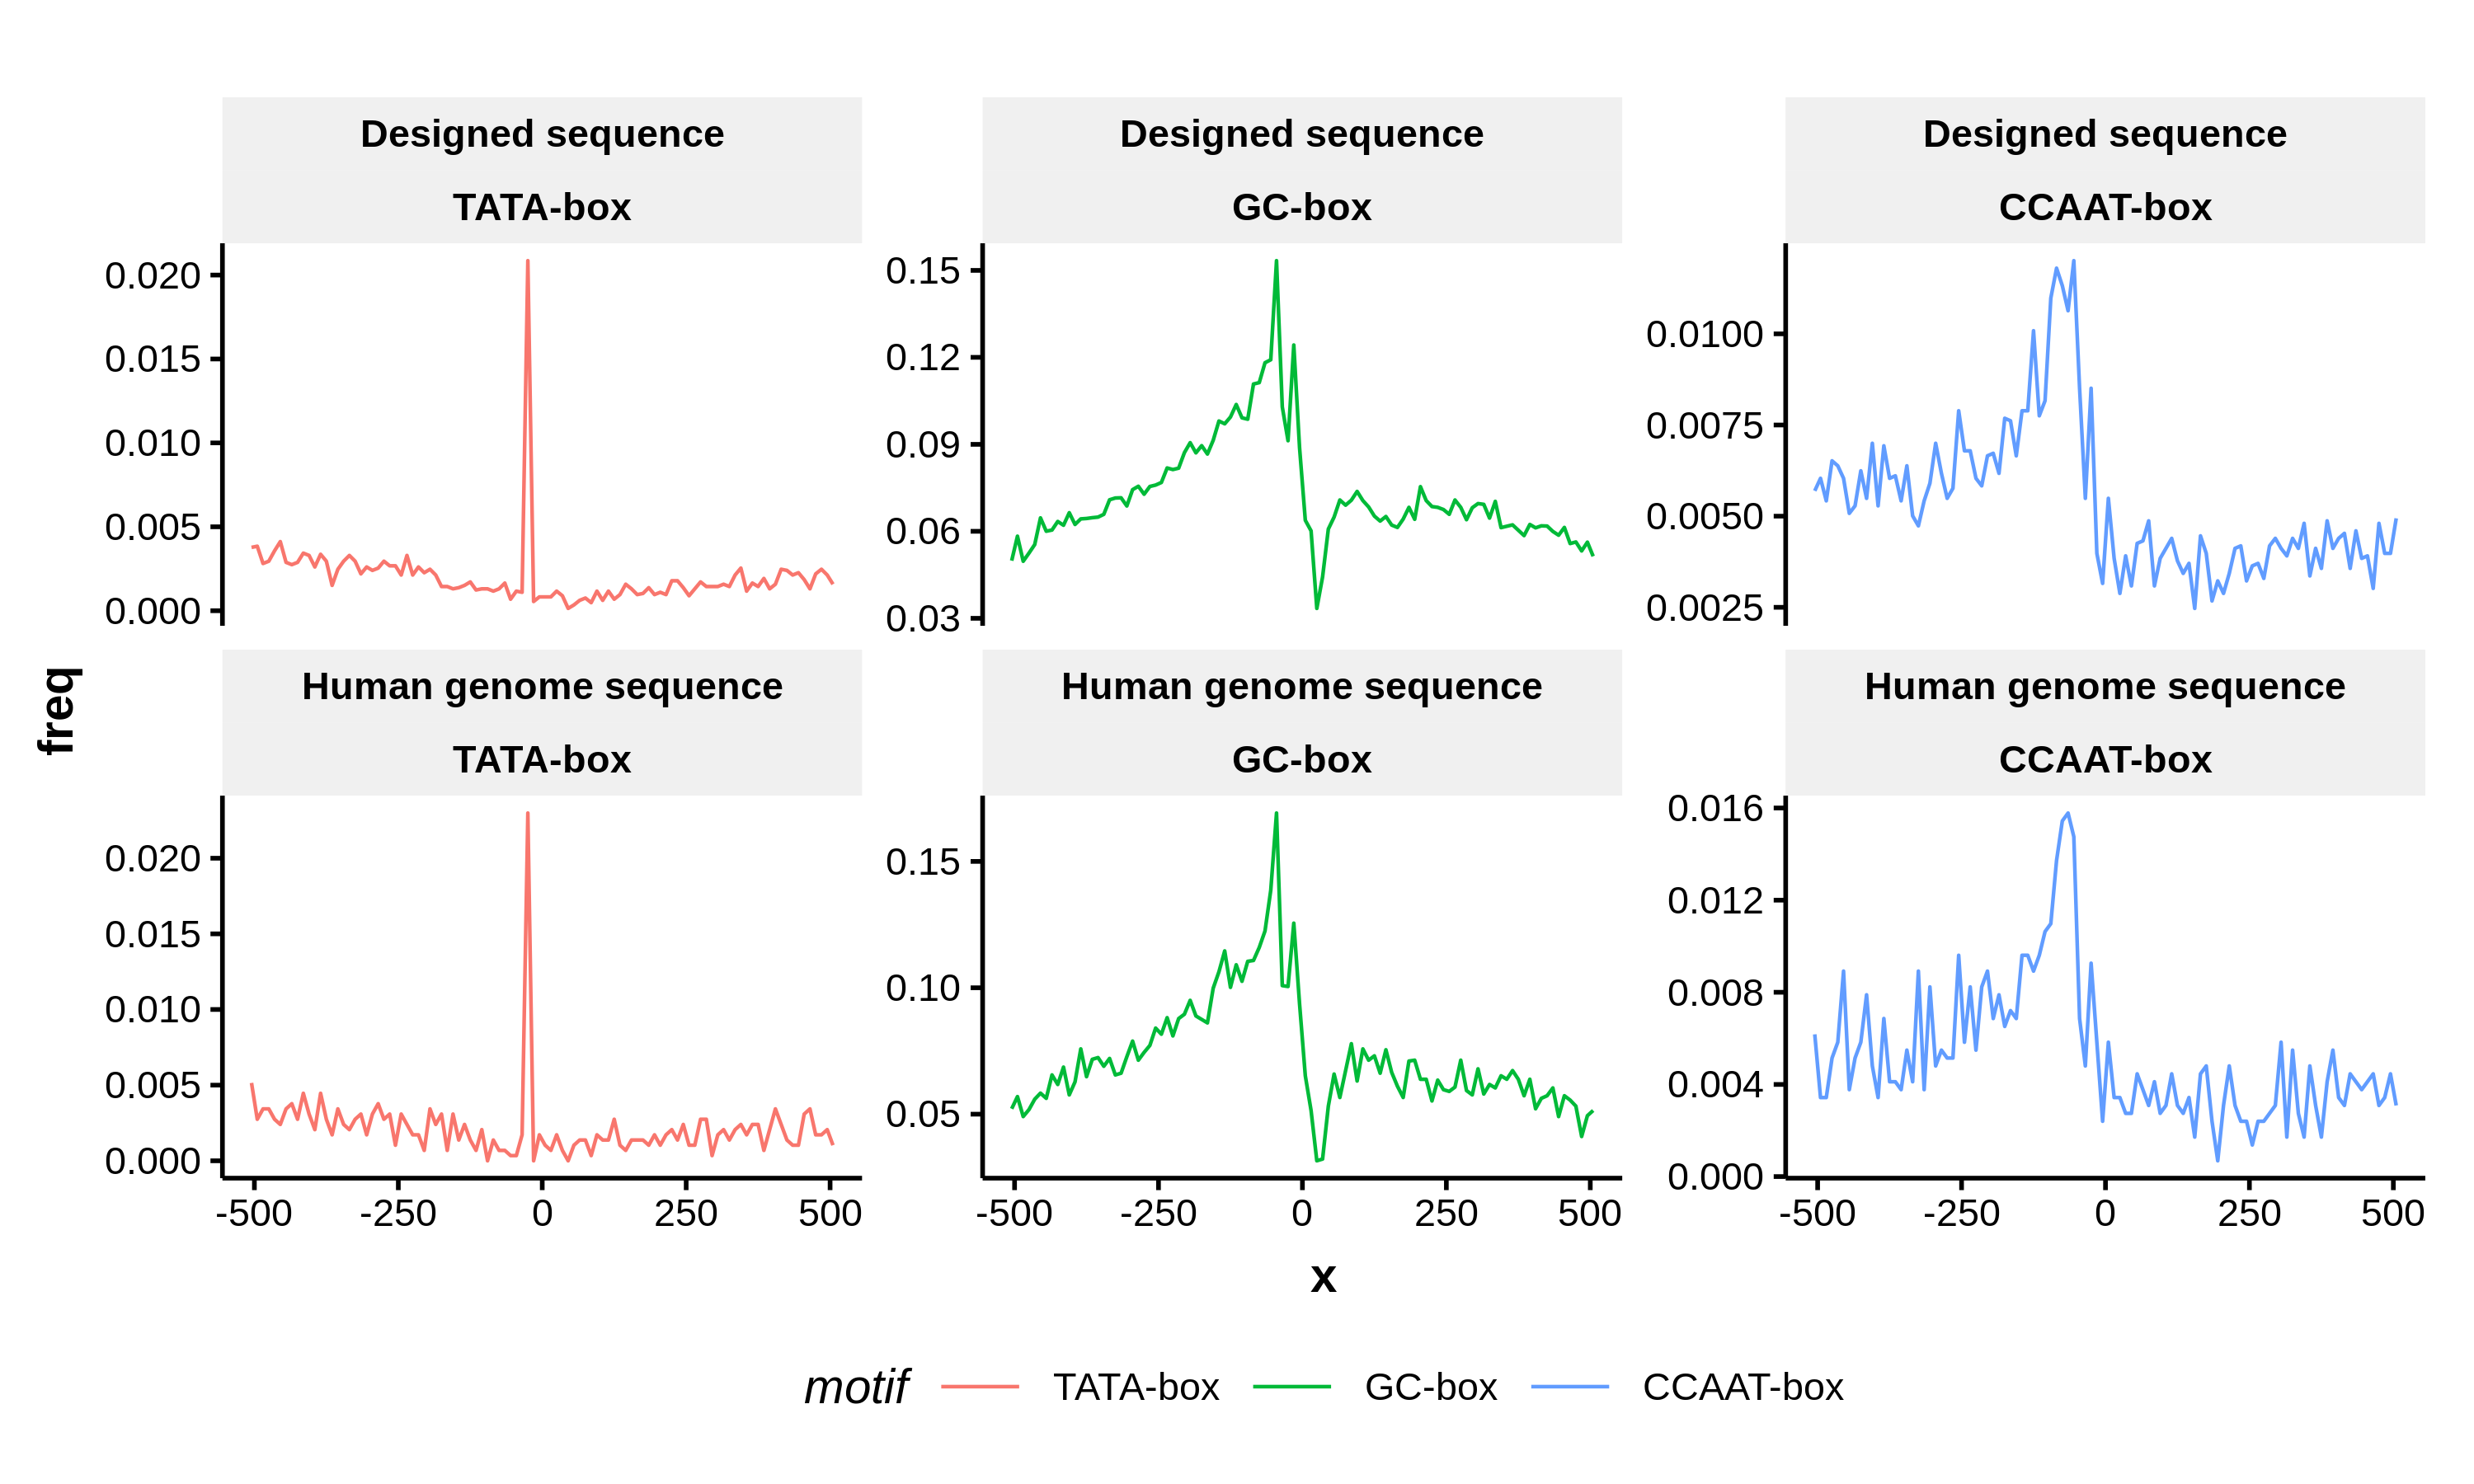

In [398]:
%%R -i s0,s1,s2,d0,d1,d2 -w 10 -h 6 --unit in --res 300
require(ggplot2)

plotdata = rbind(data.frame(x=seq(-505,505, by=10), freq=s0, motif='TATA-box', type='Designed sequence'),
    data.frame(x=seq(-505,505, by=10), freq=s1, motif='GC-box', type='Designed sequence'),
    data.frame(x=seq(-505,505, by=10), freq=s2, motif='CCAAT-box', type='Designed sequence'),
                 
    data.frame(x=seq(-505,505, by=10), freq=d0, motif='TATA-box', type='Human genome sequence'),
    data.frame(x=seq(-505,505, by=10), freq=d1, motif='GC-box', type='Human genome sequence'),
    data.frame(x=seq(-505,505, by=10), freq=d2, motif='CCAAT-box', type='Human genome sequence'))
p=ggplot(plotdata)+geom_line(aes(x=x,y=freq, color=motif))+
    facet_wrap(type~motif, scales='free_y')+theme_Publication()
ggsave('./figures/seq_motifdist.pdf', device=cairo_pdf)
p

R[write to console]: Saving 10 x 6 in image



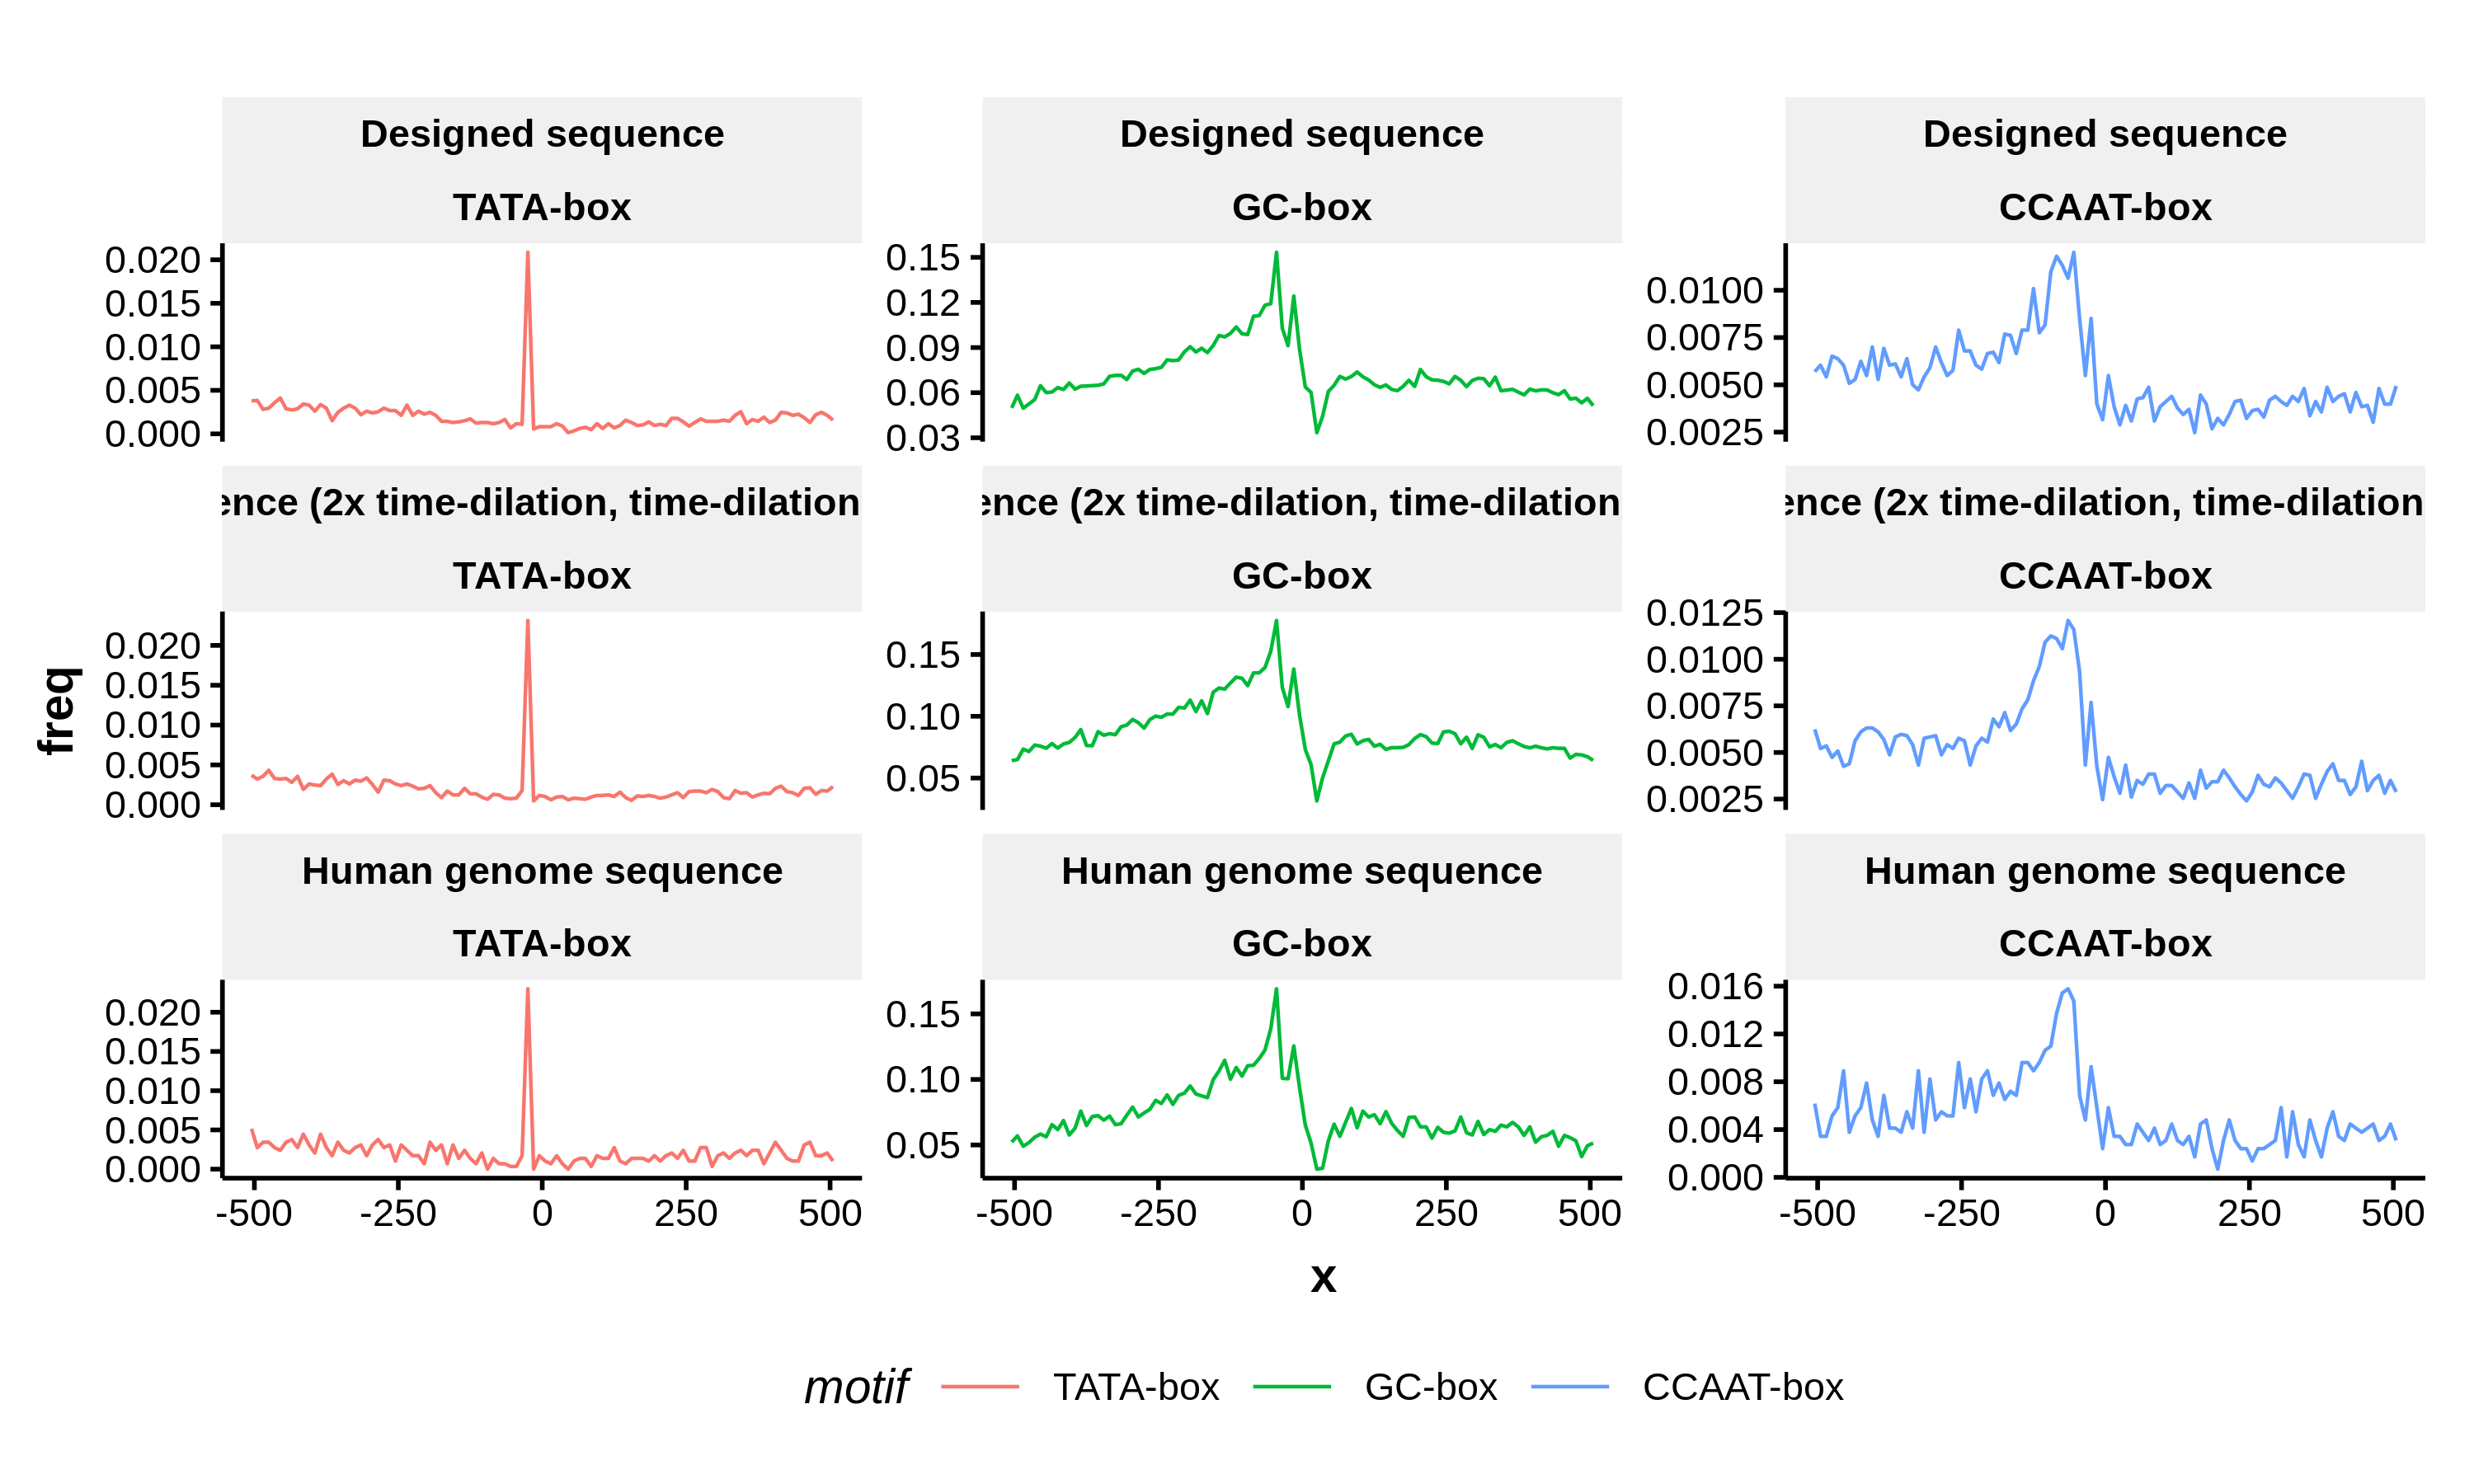

In [51]:
%%R -i s0,s1,s2,s02,s12,s22,d0,d1,d2 -w 10 -h 6 --unit in --res 300
require(ggplot2)

plotdata = rbind(data.frame(x=seq(-505,505, by=10), freq=s0, motif='TATA-box', type='Designed sequence'),
    data.frame(x=seq(-505,505, by=10), freq=s1, motif='GC-box', type='Designed sequence'),
    data.frame(x=seq(-505,505, by=10), freq=s2, motif='CCAAT-box', type='Designed sequence'),

    data.frame(x=seq(-505,505, by=10), freq=s02, motif='TATA-box', type='Designed sequence (2x time-dilation, time-dilation start-time 25%)'),
    data.frame(x=seq(-505,505, by=10), freq=s12, motif='GC-box', type='Designed sequence (2x time-dilation, time-dilation start-time 25%)'),
    data.frame(x=seq(-505,505, by=10), freq=s22, motif='CCAAT-box', type='Designed sequence (2x time-dilation, time-dilation start-time 25%)'),
                 
                 
    data.frame(x=seq(-505,505, by=10), freq=d0, motif='TATA-box', type='Human genome sequence'),
    data.frame(x=seq(-505,505, by=10), freq=d1, motif='GC-box', type='Human genome sequence'),
    data.frame(x=seq(-505,505, by=10), freq=d2, motif='CCAAT-box', type='Human genome sequence'))
p=ggplot(plotdata)+geom_line(aes(x=x,y=freq, color=motif))+
    facet_wrap(type~motif, scales='free_y')+theme_Publication()
ggsave('./figures/seq_motifdist2.pdf', device=cairo_pdf)
p

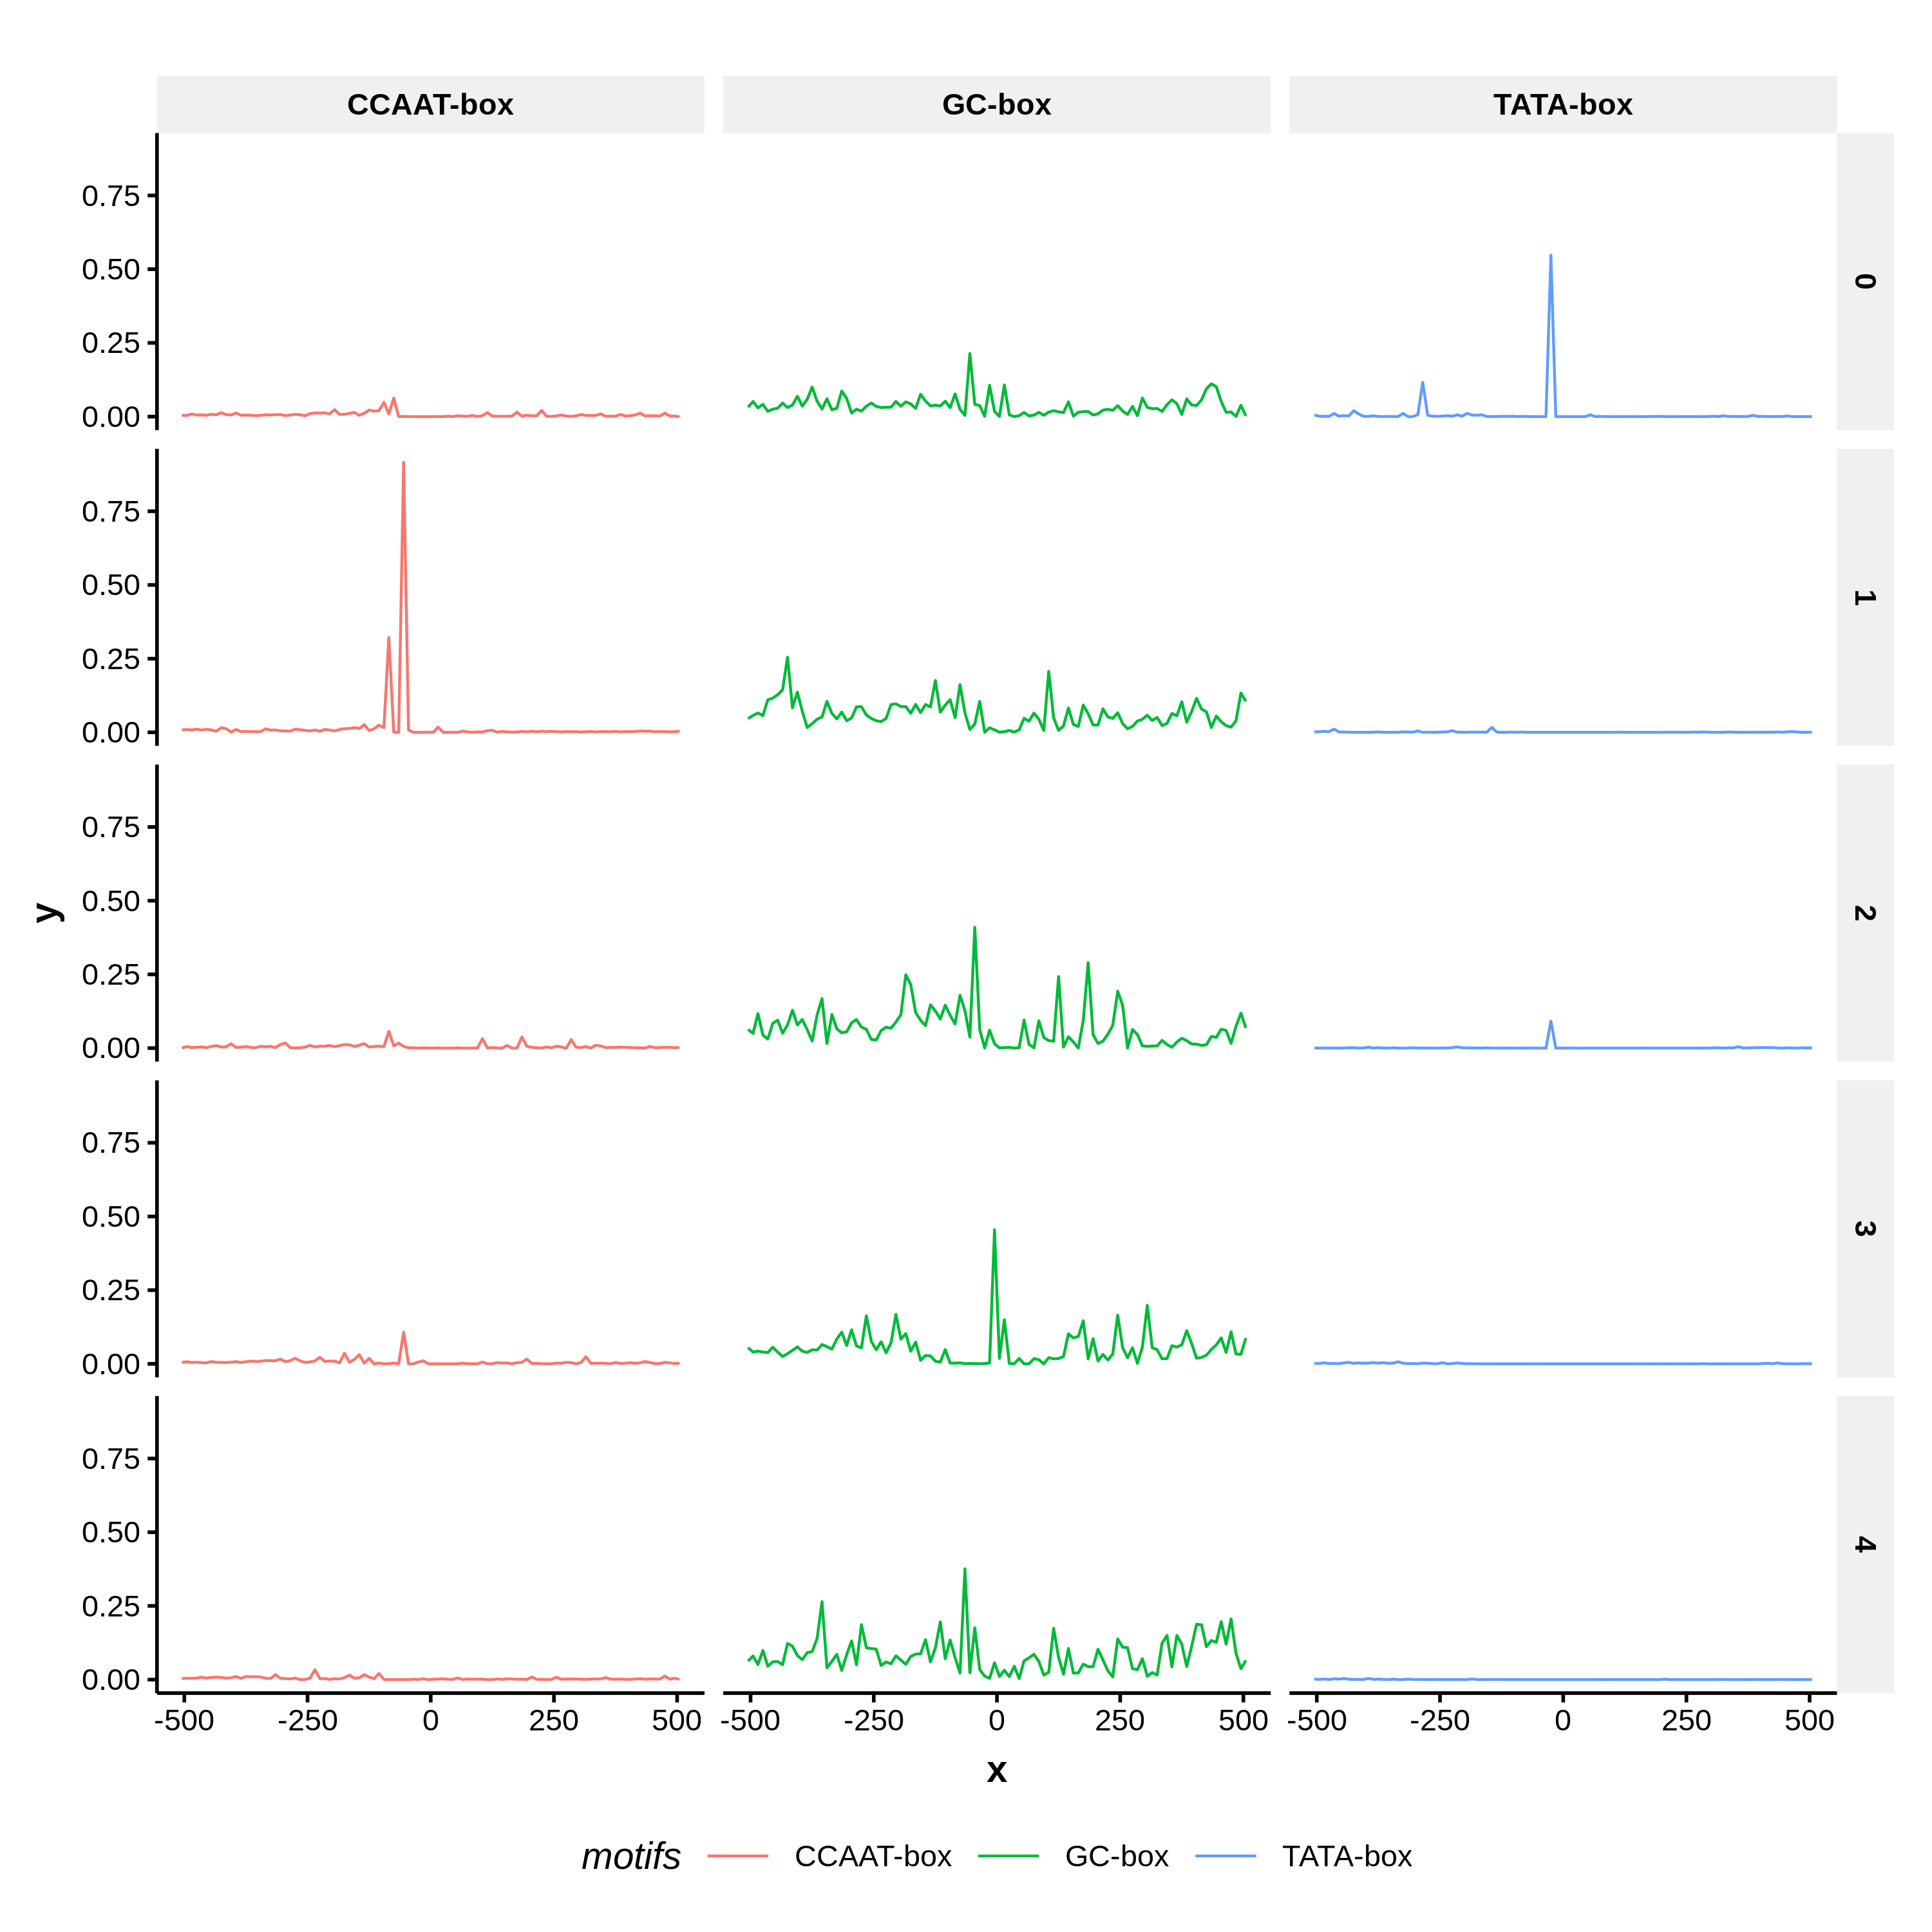

In [375]:
%%R -i plotdata -w 10 -h 10 --unit in --res 300
require(ggplot2)

p=ggplot(plotdata)+geom_line(aes(x=x,y=y, color=motifs))+
    facet_grid(tsses~motifs)+theme_Publication()
#ggsave('./figures/seq_motifdist.pdf', device=cairo_pdf)
p

R[write to console]: Saving 10 x 10 in image



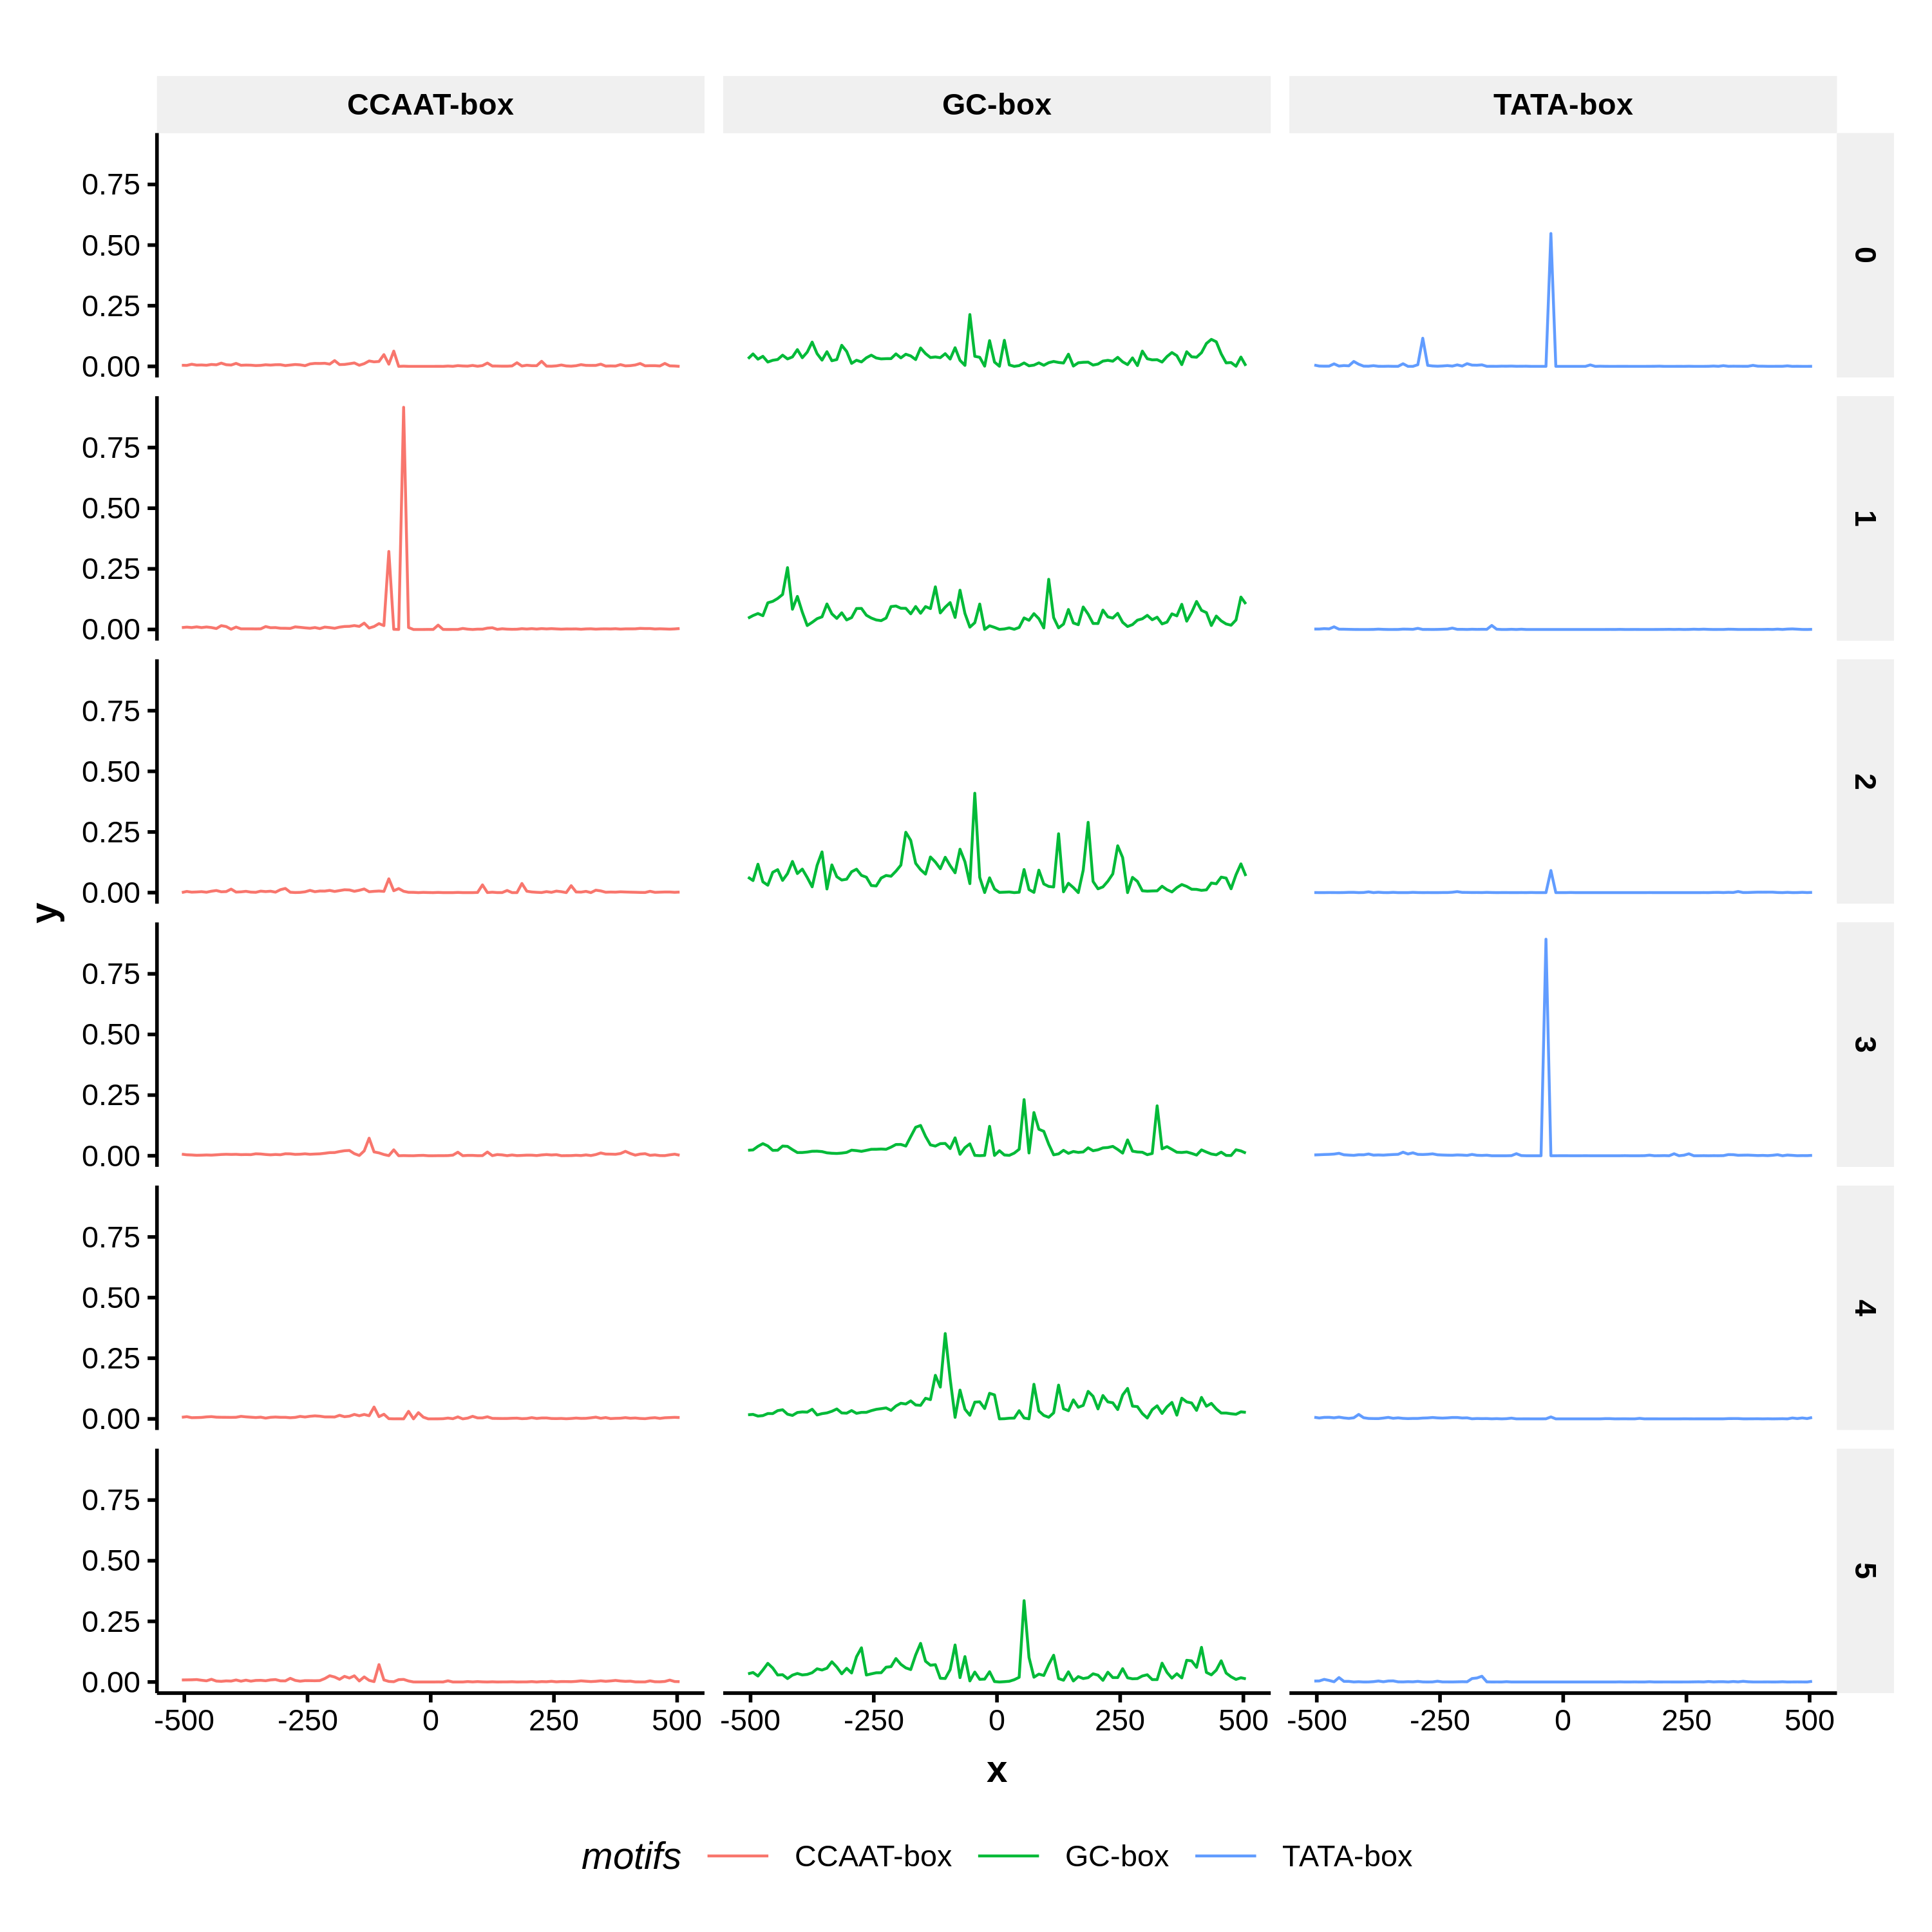

In [394]:
%%R -i plotdata -w 10 -h 10 --unit in --res 300
require(ggplot2)

p=ggplot(plotdata)+geom_line(aes(x=x,y=y, color=motifs))+
    facet_grid(tsses~motifs)+theme_Publication()
ggsave('./figures/motifdist_examples.pdf', device=cairo_pdf)
p